# Project 2 - Supervised Learning

### Let's first check the data in the **train.csv**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
import time

train_data_imbalanced = pd.read_csv('train.csv')


### Let's check if there are columns with missing values and change the non-numeric columns to numeric

In [2]:
cols_with_na = train_data_imbalanced.columns[train_data_imbalanced.isna().any()].tolist()
print('Columns with missing values:', cols_with_na)

train_data_imbalanced.drop('policy_id', axis=1, inplace=True)
train_data_imbalanced['area_cluster'] = train_data_imbalanced['area_cluster'].apply(lambda x: x.replace('C', ''))
train_data_imbalanced = pd.get_dummies(train_data_imbalanced,
                            columns=['segment', 'fuel_type', 'engine_type', 'rear_brakes_type', 'steering_type'])
train_data_imbalanced['model'] = train_data_imbalanced['model'].apply(lambda x: x.replace('M', ''))
train_data_imbalanced = train_data_imbalanced.replace({"Yes": True, "No": False})
encoder = LabelEncoder()
train_data_imbalanced['transmission_type'] = encoder.fit_transform(train_data_imbalanced['transmission_type'])

train_data_imbalanced['max_torque'] = train_data_imbalanced['max_torque'].apply(
    lambda s: float(s.split('Nm@')[0]) * float(s.split('Nm@')[1].replace('rpm', '')))
train_data_imbalanced['max_power'] = train_data_imbalanced['max_power'].apply(
    lambda s: float(s.split('bhp@')[0]) * float(s.split('bhp@')[1].replace('rpm', '')))

Columns with missing values: []


As we can see, there are no missing values in our data set

### Now lets deal with the sampling problem: our dataset contains a significant class imbalance problem in the target column ("is_claim"), with the majority of observations belonging to the 0 class and only a minority belonging to the 1 class.

In [3]:
claimed = train_data_imbalanced[train_data_imbalanced['is_claim'] == 1]
not_claimed = train_data_imbalanced[train_data_imbalanced['is_claim'] == 0]
sample_size = min(len(claimed), len(not_claimed))
train_data = pd.concat([claimed.sample(n=sample_size), not_claimed.sample(n=sample_size)])

print(train_data.head())
print(len(train_data))

       policy_tenure  age_of_car  age_of_policyholder area_cluster   
486         0.011484        0.00             0.442308            5  \
14103       0.225361        0.03             0.317308            7   
44119       1.154077        0.04             0.471154           13   
52162       1.153476        0.05             0.528846            8   
34576       1.058384        0.22             0.548077            8   

       population_density  make model  max_torque  max_power  airbags  ...   
486                 34738     1     1    210000.0   242160.0        2  ...  \
14103                6112     1     1    210000.0   242160.0        2  ...   
44119                5410     5     9    350000.0   352404.0        2  ...   
52162                8794     3     4    687500.0   453800.0        6  ...   
34576                8794     3     4    687500.0   453800.0        6  ...   

       engine_type_F8D Petrol Engine  engine_type_G12B   
486                             True             Fal



We had to have the same number of claims and not claims to avoid **imbalance**

### Let's now get some more general information of our features

In [4]:
#print(train_data.describe())
#sb.pairplot(train_data)

After analysing the output, we can verify that there are no major outliers that require work.
We can also conclude that there are some variables that seem to have no correlation with the `is_claim` feature.

### Now let's check what features have no correlation with the test feature

We will also create some subsets with:
  - Data without >= 0.9 correlated data
  - Data without >= 0.8 correlated data
  - Data without >= 0.7 correlated data
  - Data correlated with the target feature

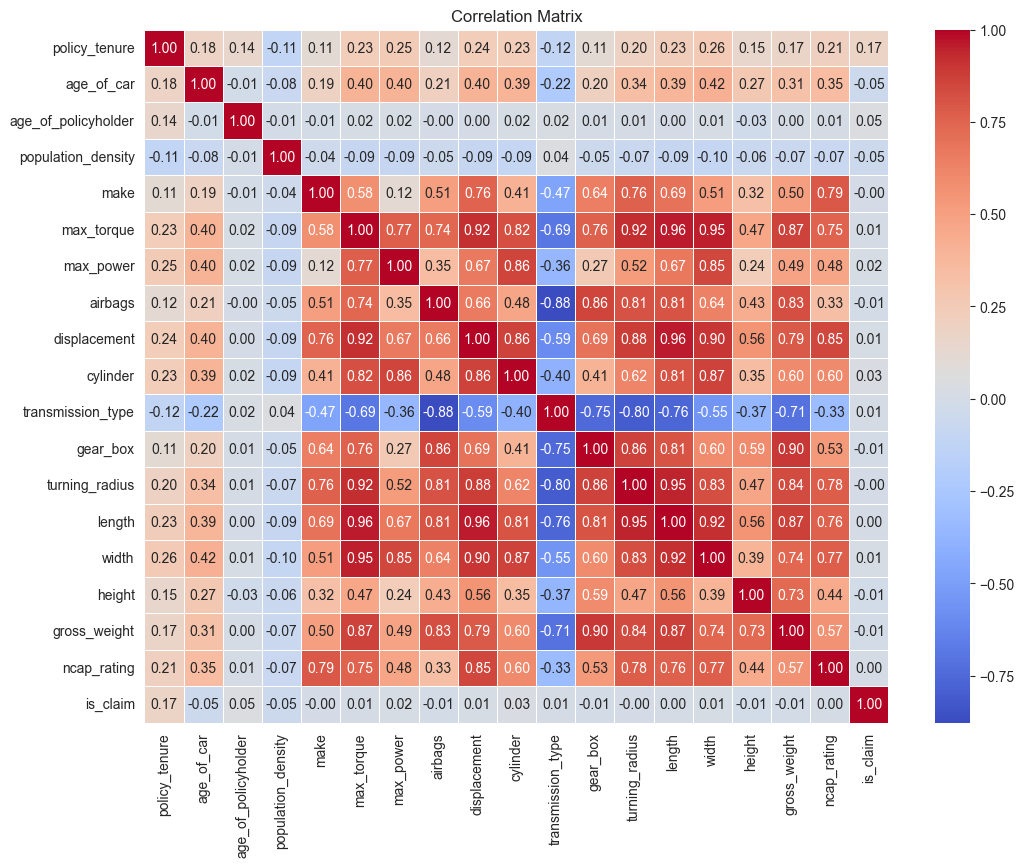

In [5]:
numeric_columns = train_data.select_dtypes(include='number')
train_data_numeric = train_data[numeric_columns.columns]


correlation_matrix = train_data_numeric.corr()

# Creating the subsets without the highly correlated features
corr_cols08 = set()
corr_cols09 = set()
corr_cols07 = set()
nocorr = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if correlation_matrix.columns[i] != correlation_matrix.columns[j] and abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[j]
            corr_cols08.add(colname)

        if correlation_matrix.columns[i] != correlation_matrix.columns[j] and abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[j]
            corr_cols09.add(colname)

        if correlation_matrix.columns[i] != correlation_matrix.columns[j] and abs(correlation_matrix.iloc[i, j]) > 0.7:
            colname = correlation_matrix.columns[j]
            corr_cols07.add(colname)
    if correlation_matrix.columns[i] != "is_claim":
        j = (len(correlation_matrix.columns) - 1)
        if abs((correlation_matrix.iloc[i, j])) < 0.02:
            colname = correlation_matrix.columns[i]
            nocorr.add(colname)

train_data_08 = train_data_numeric.drop(columns=corr_cols08)
train_data_09 = train_data_numeric.drop(columns=corr_cols09)
train_data_07 = train_data_numeric.drop(columns=corr_cols07)
nocorr.discard('age_of_policyholder')
train_data_nocorr = train_data_numeric.drop(columns=nocorr)

plt.figure(figsize=(12, 9))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

To test the relation between the features we created a new feature that contains a combination of other ones:

- Create a new column `combination` that uses the most important features to the target
- Use some preprocessing tools (Polynomial and Scaler) to create some more features

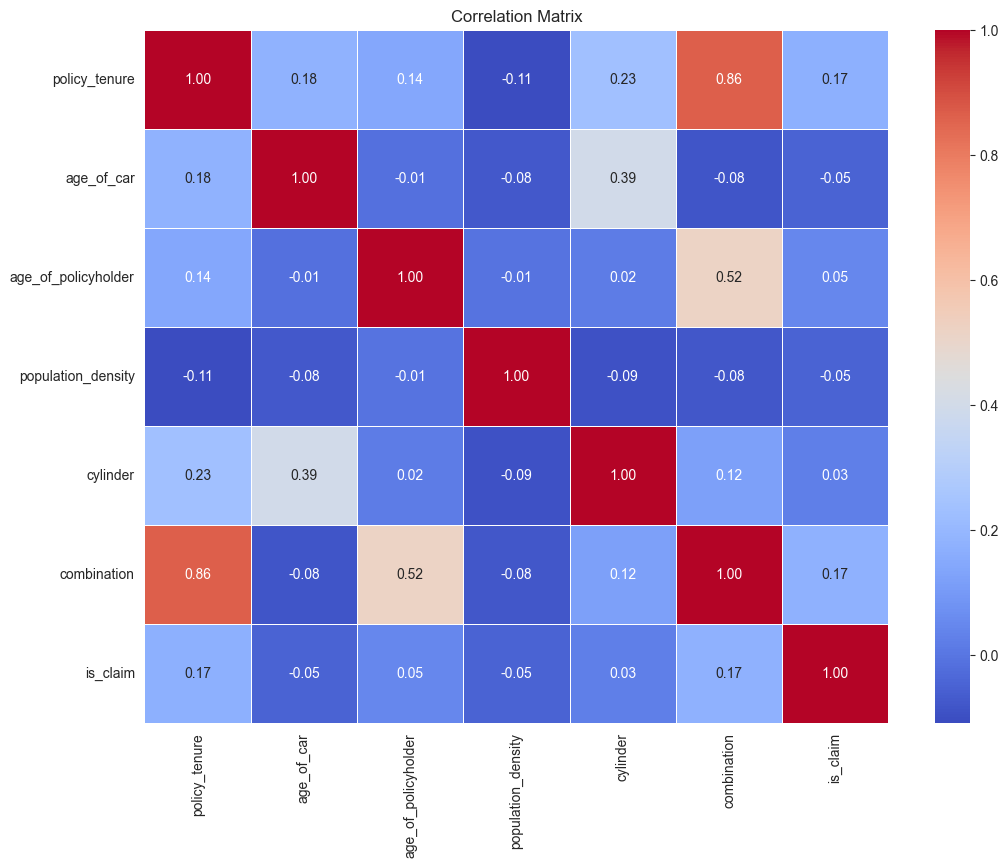

In [6]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

# Combination feature

train_data_nocorr.insert(len(train_data_nocorr.columns) - 1, 'combination', train_data_nocorr['policy_tenure'] * train_data_nocorr['age_of_policyholder'] - train_data_nocorr['age_of_car'])

correlation_matrix = train_data_nocorr.corr()

plt.figure(figsize=(12, 9))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Polynomial

target = "is_claim"

poly = PolynomialFeatures(degree=2)

X = train_data_nocorr.drop(target, axis=1)
y = train_data_nocorr[target]

X_poly = poly.fit_transform(X)

train_data_poly = pd.concat([pd.DataFrame(X_poly), y], axis=1).dropna()


# Scale
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

train_data_scaled = pd.concat([pd.DataFrame(X_scaled), y], axis=1).dropna()

# Polynomial and Scale

X_poly_scaled = poly.fit_transform(X_scaled)

train_data_poly_scaled = pd.concat([pd.DataFrame(X_poly_scaled), y], axis=1).dropna()



### Now we are going to check if there are any nonnumerical features that have a high impact on the target feature

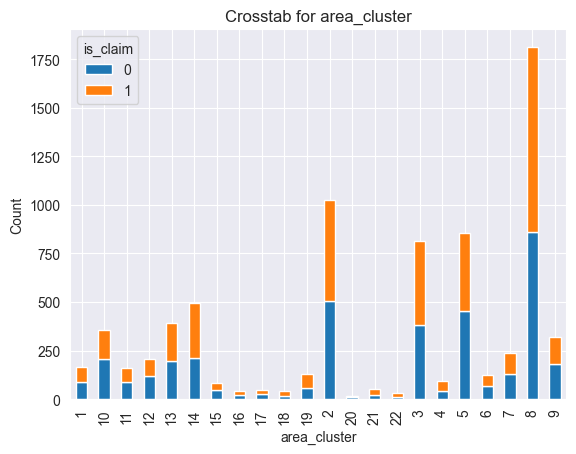

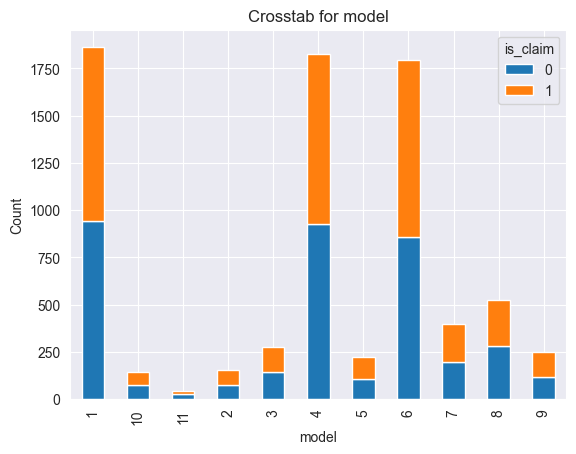

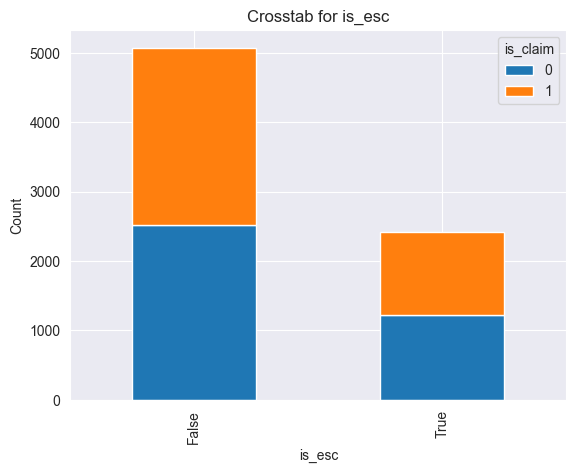

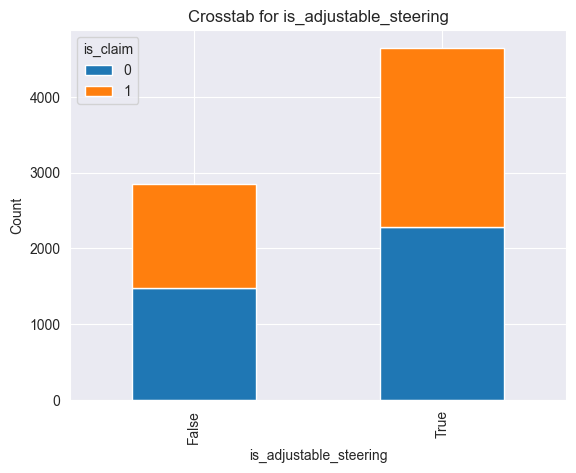

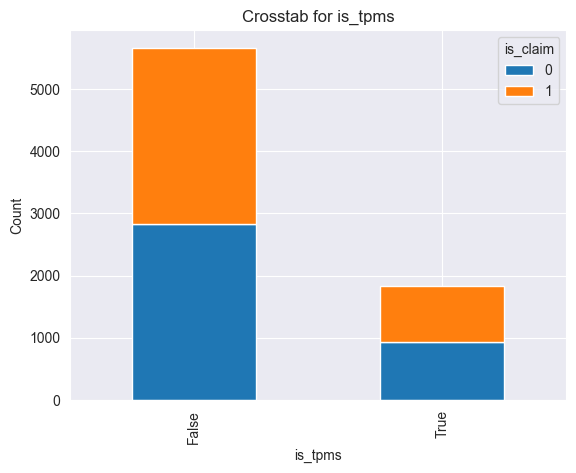

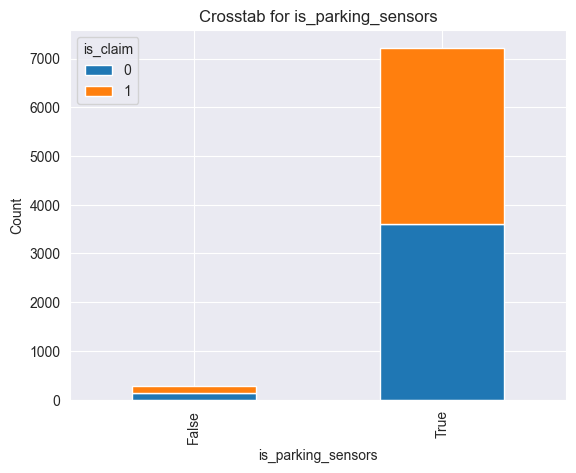

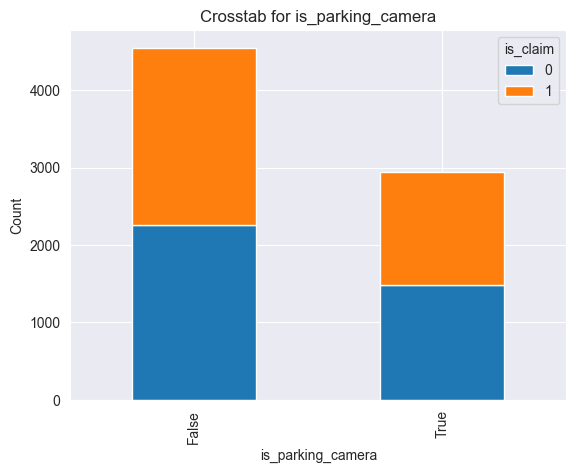

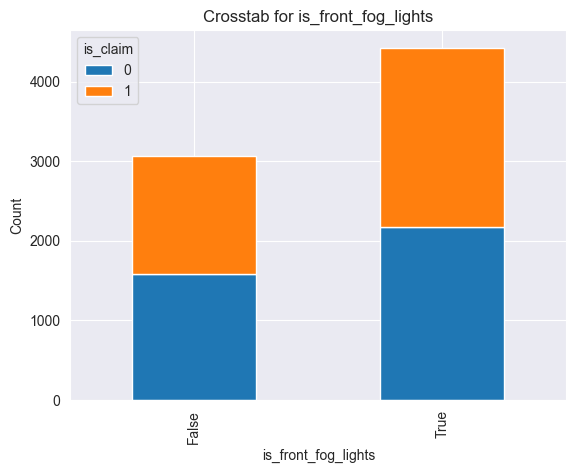

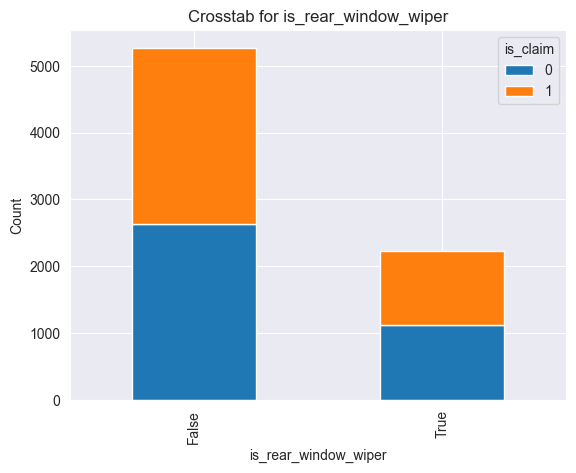

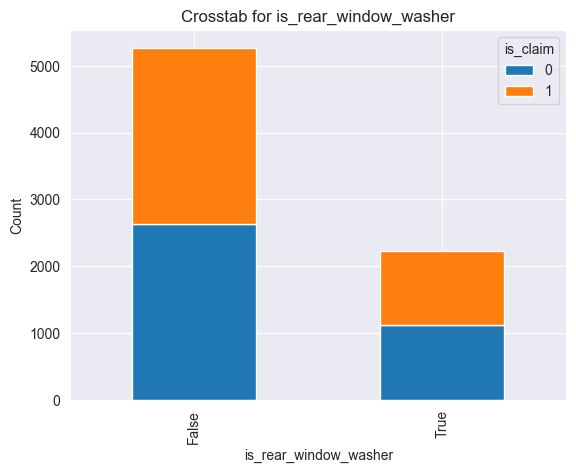

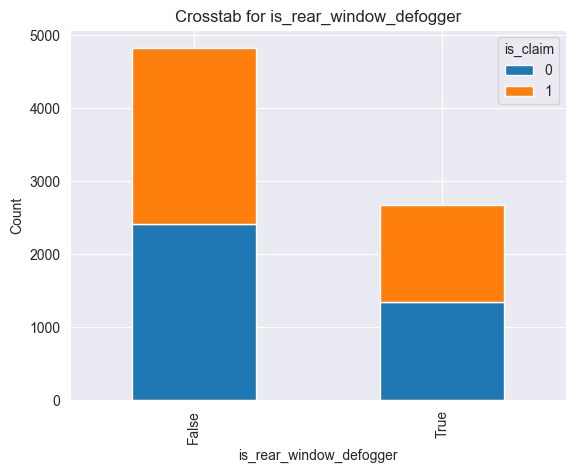

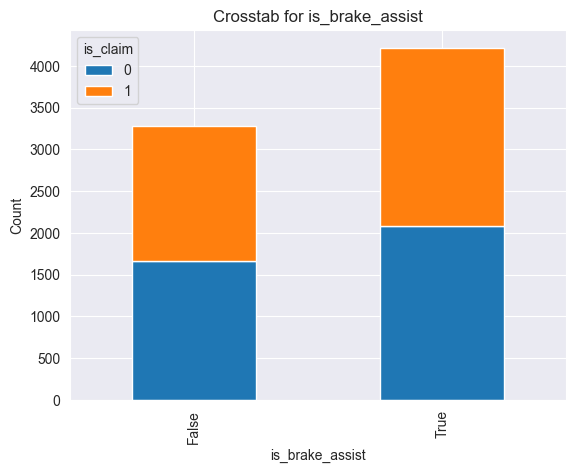

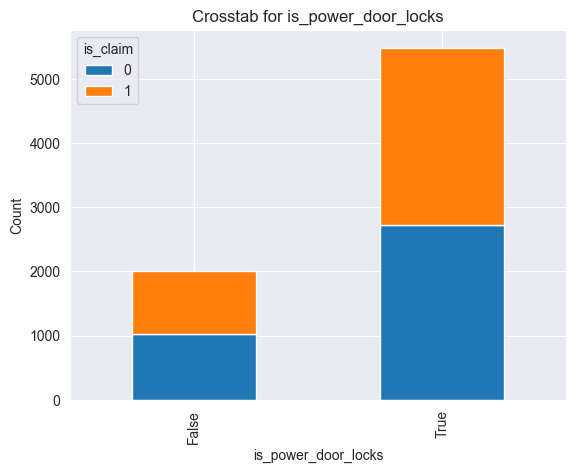

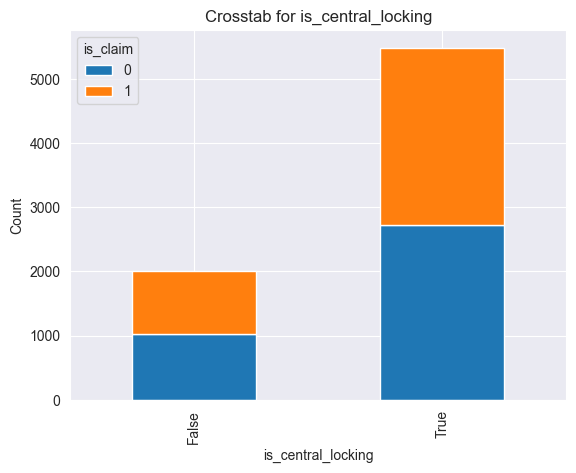

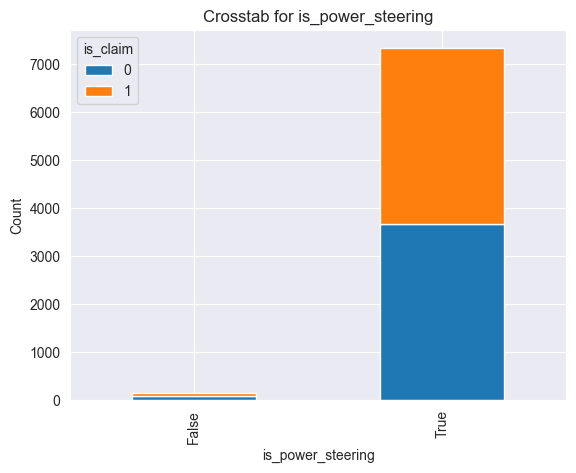

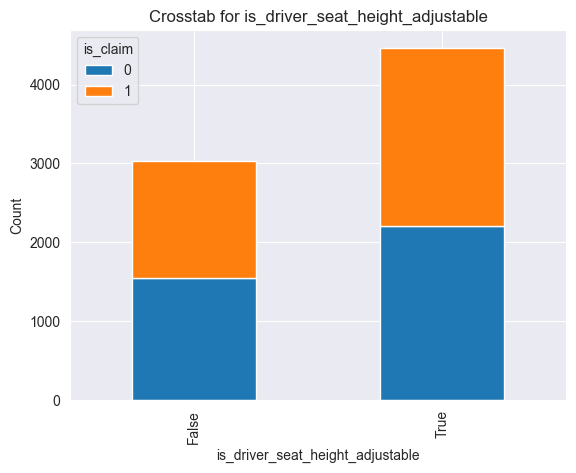

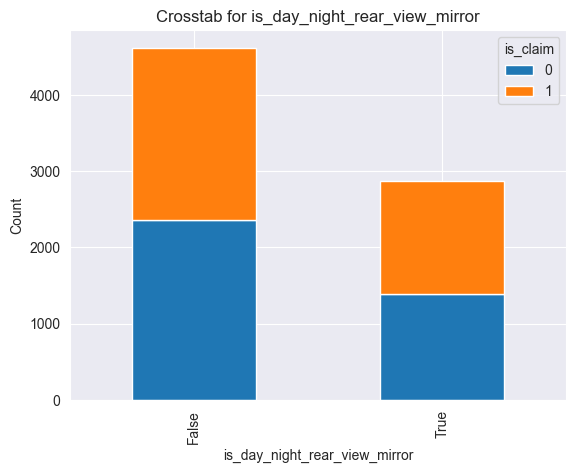

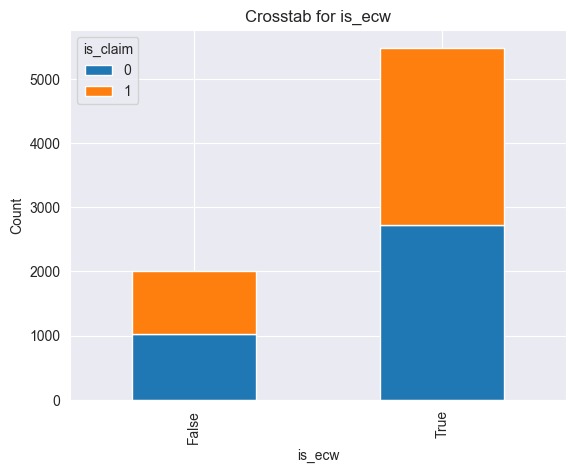

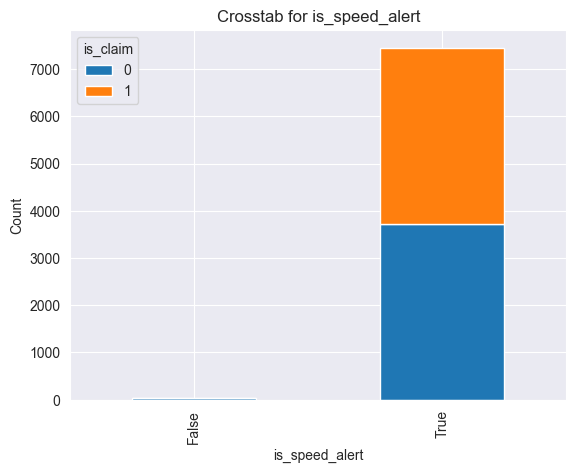

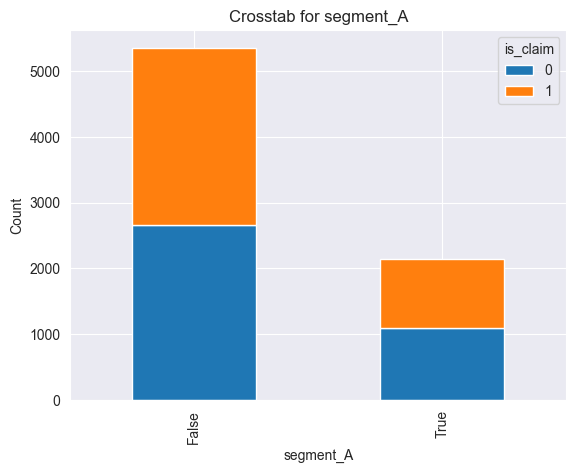

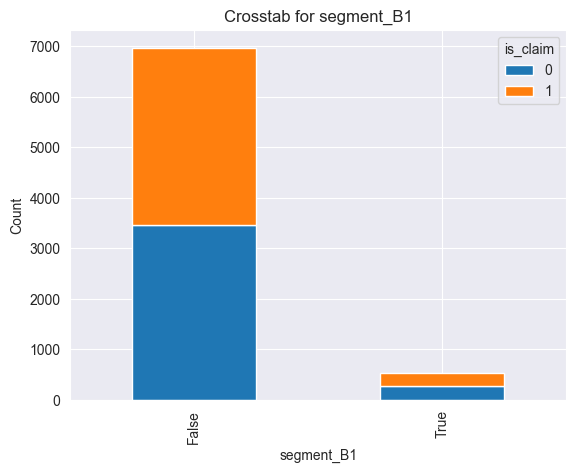

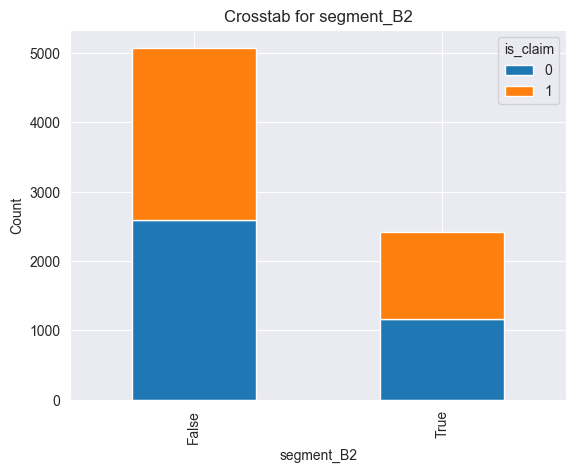

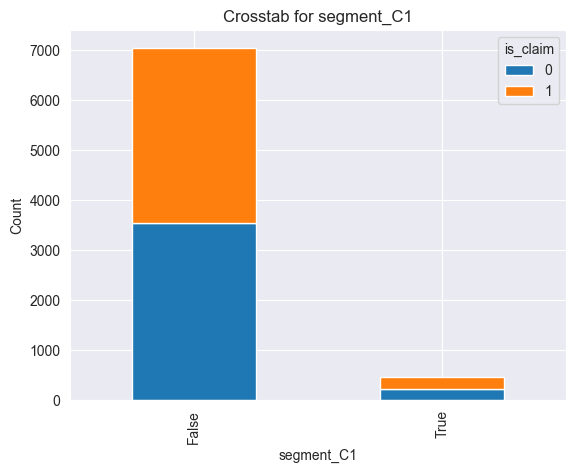

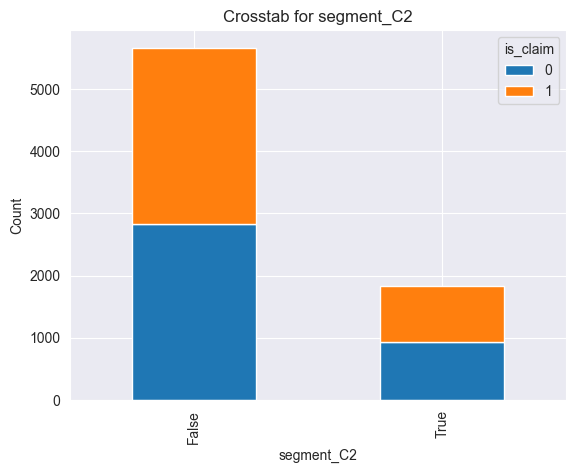

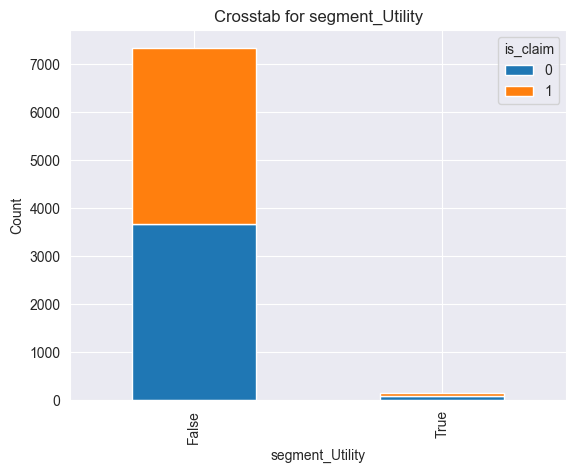

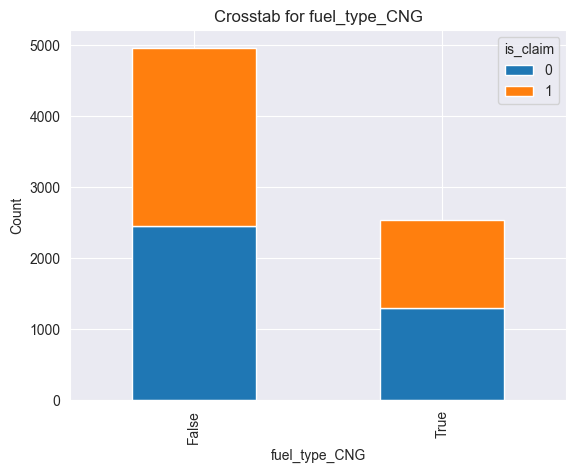

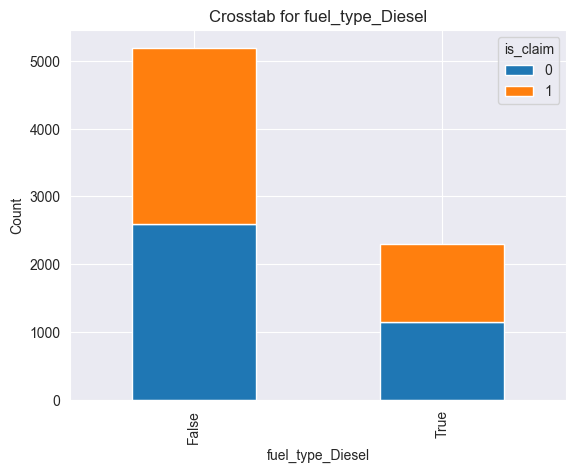

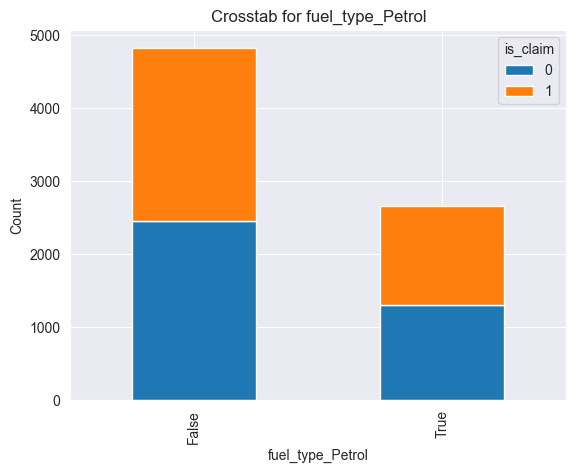

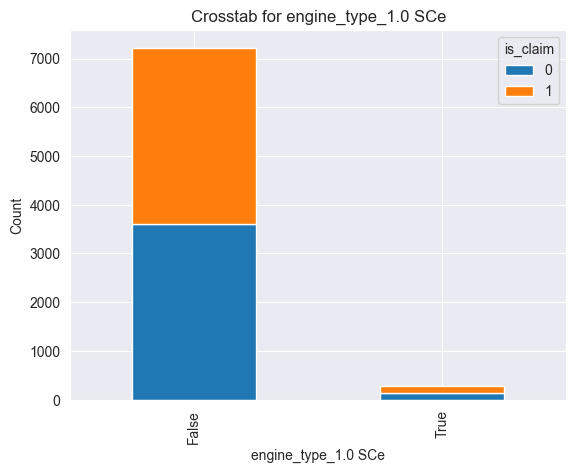

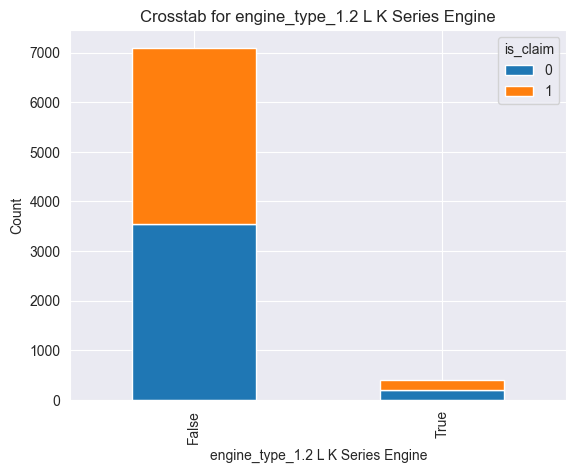

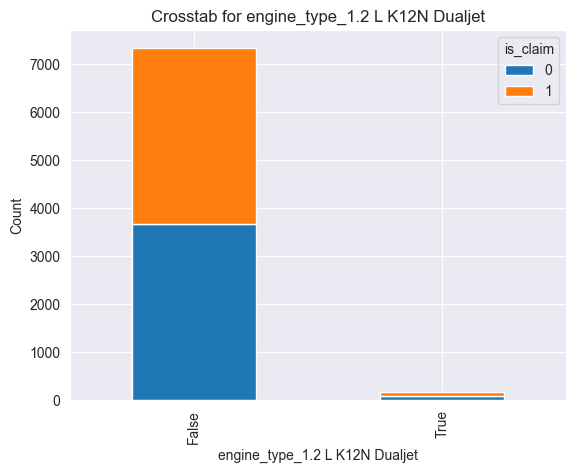

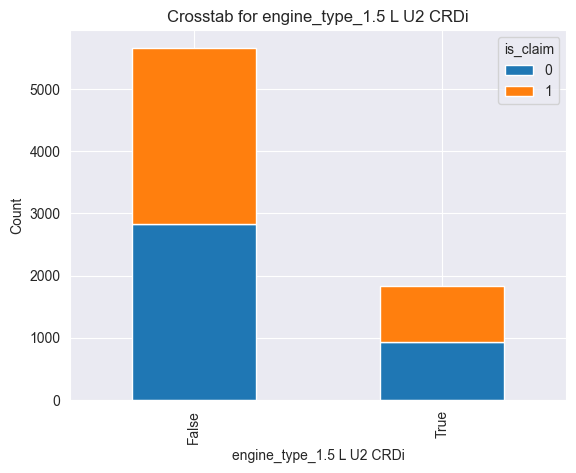

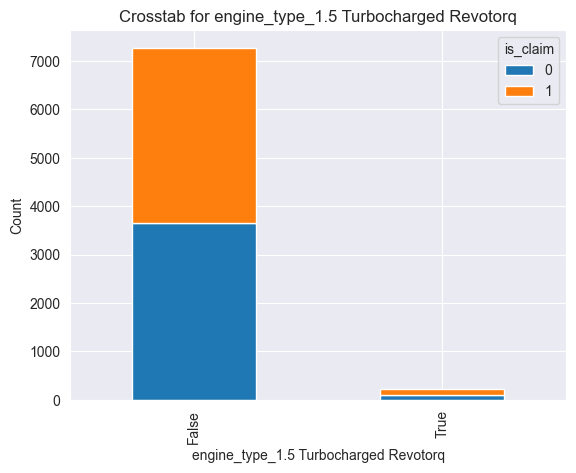

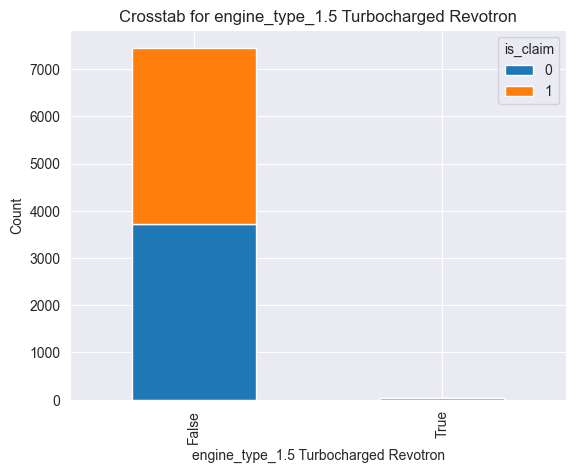

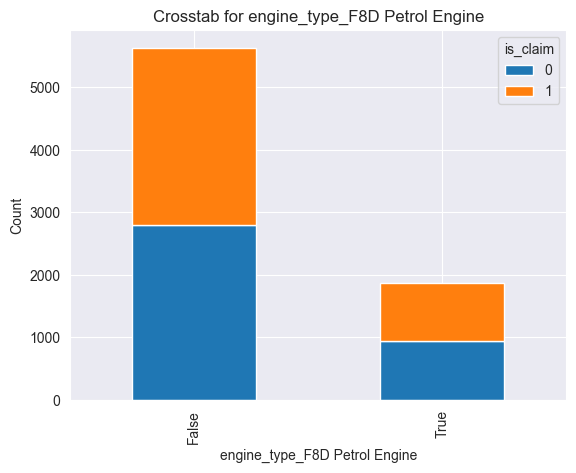

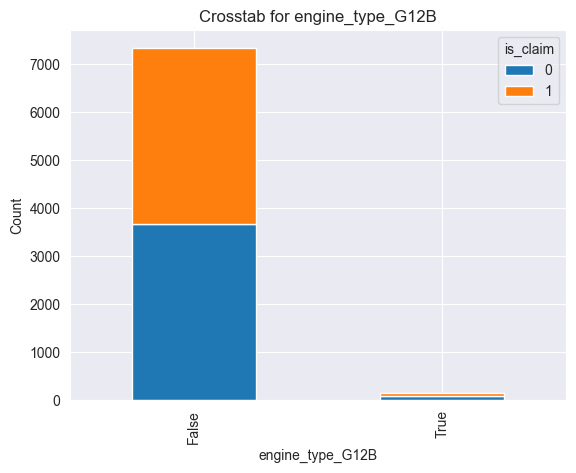

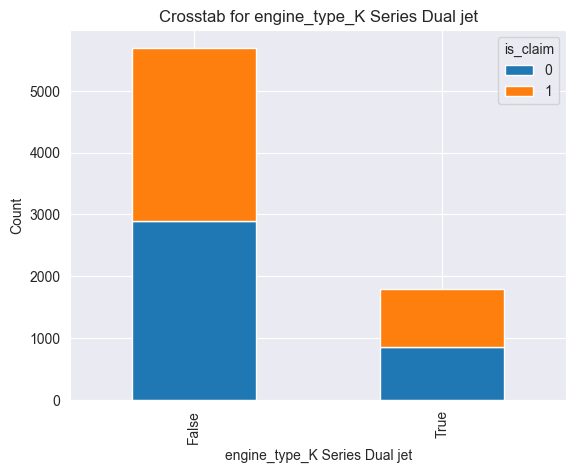

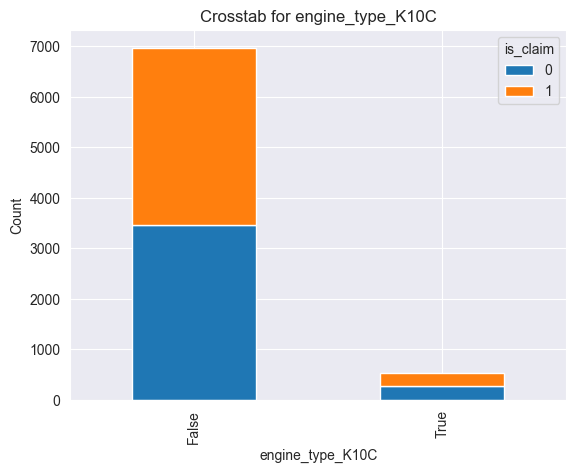

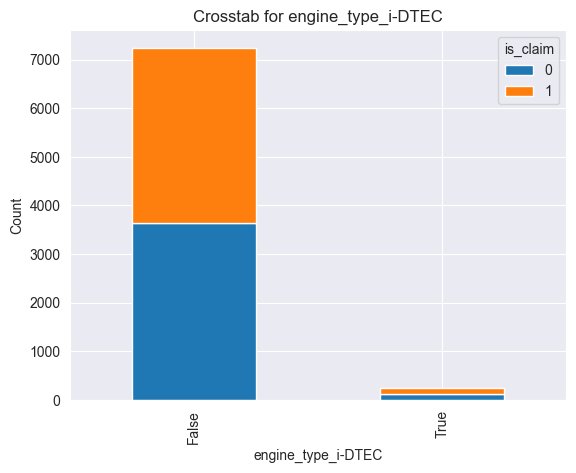

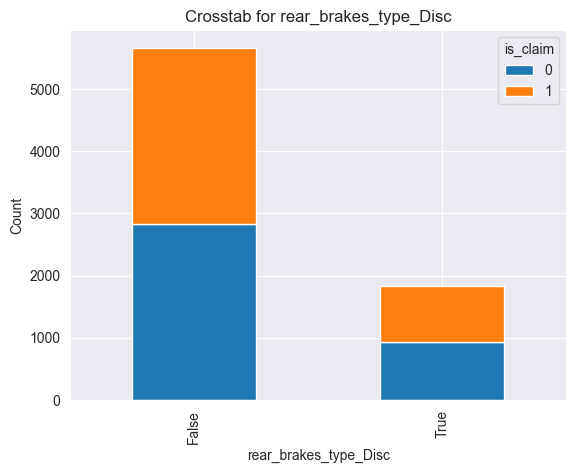

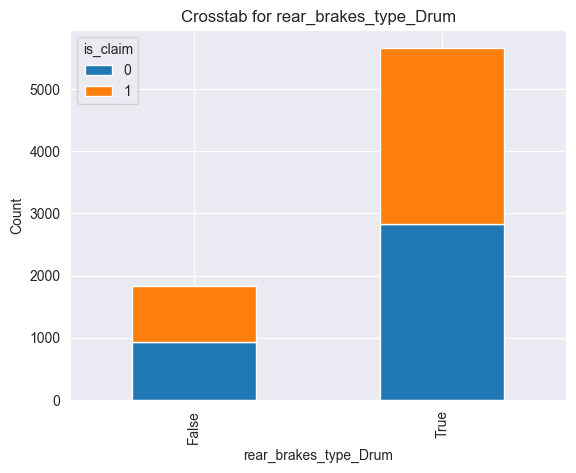

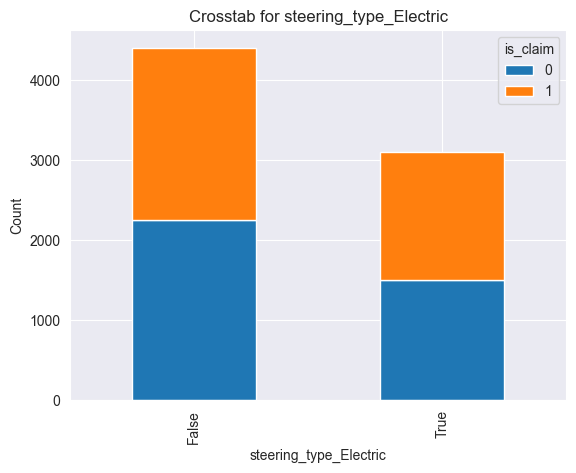

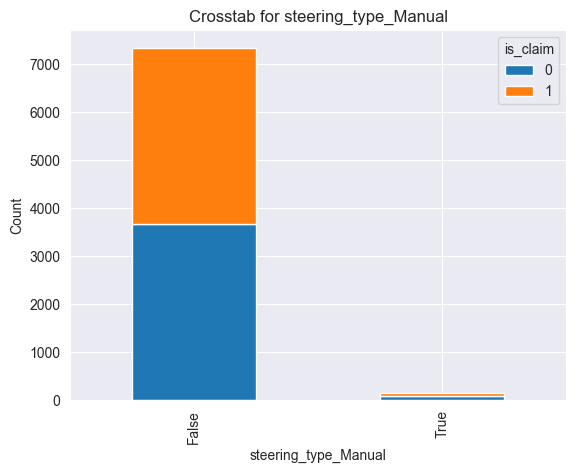

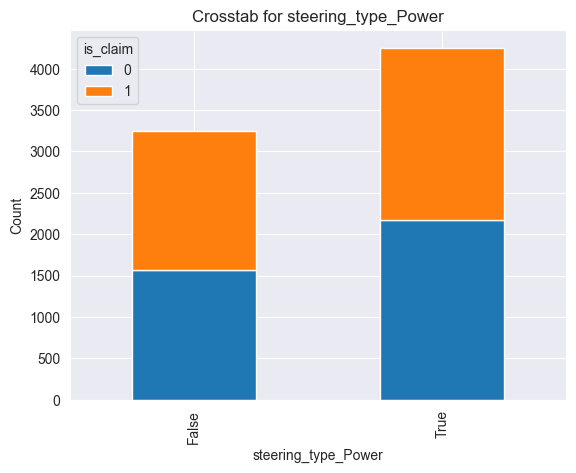

In [10]:
non_numeric_columns = train_data.select_dtypes(exclude='number')
for column in non_numeric_columns:
    if 'id' in column: continue
    crosstab_table = pd.crosstab(train_data[column], train_data['is_claim'])
    crosstab_table.plot(kind='bar', stacked=True)

    plt.title(f'Crosstab for {column}')
    plt.xlabel(column)
    plt.ylabel('Count')

    plt.show()



Numeric features don't correlate significantly with the `is_claim` feature, but there are others features that strongly correlate with each other, which might give more strength to those values, something that we want to avoid.
A good way of avoiding it is to remove the column that correlate too much with another. For this assignment, we tested removing columns with correlation greater than 0.70, 0.80 and 0.90.

In non-numeric features we didn't get a clear separation but there are some choices that are more favorable. For example in the feature `segment`, people insure more an `A` than a `Utility` value

### Let's now dive into the classifier methods

We have done an initial comparison of all the algorithms

In [7]:
classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'Neural Network': MLPClassifier(),
    'K-NN': KNeighborsClassifier(),
    'SVM': SVC(),
    'SGD': SGDClassifier()
}
target_column = "is_claim"
X = train_data_imbalanced.drop(target_column, axis=1)
y = train_data_imbalanced[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        Classifier              Confusion Matrix  Precision    Recall   
0    Decision Tree  [[15147, 1270], [1051, 110]]   0.878617  0.867960  \
1    Decision Tree  [[15146, 1271], [1049, 112]]   0.878805  0.868017   
2    Decision Tree  [[15150, 1267], [1053, 108]]   0.878444  0.868017   
3    Decision Tree  [[15144, 1273], [1056, 105]]   0.878104  0.867505   
4    Decision Tree  [[15153, 1264], [1048, 113]]   0.878957  0.868472   
5   Neural Network    [[8906, 7511], [596, 565]]   0.879991  0.538798   
6   Neural Network       [[16417, 0], [1161, 0]]   0.938314  0.933952   
7   Neural Network       [[16417, 0], [1161, 0]]   0.938314  0.933952   
8   Neural Network       [[16417, 0], [1161, 0]]   0.938314  0.933952   
9   Neural Network       [[16417, 0], [1161, 0]]   0.938314  0.933952   
10            K-NN      [[16366, 51], [1155, 6]]   0.879337  0.931392   
11            K-NN      [[16366, 51], [1155, 6]]   0.879337  0.931392   
12            K-NN      [[16366, 51], [1155, 6]]   

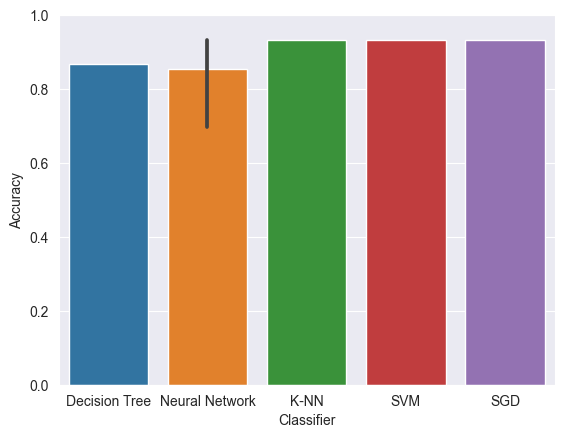

In [8]:
# Train and evaluate the classifiers
results = []

for (name, classifier) in classifiers.items():

    for _ in range(5):
        # Train the model
        start_time = time.time()
        classifier.fit(X_train, y_train)
        train_time = time.time() - start_time

        # Test the model
        start_time = time.time()
        y_pred = classifier.predict(X_test)
        test_time = time.time() - start_time

        # Calculate evaluation metrics
        conf_matrix = confusion_matrix(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_test, y_pred, average='weighted')
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Store the results
        results.append({
            'Classifier': name,
            'Confusion Matrix': conf_matrix,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Train Time': train_time,
            'Test Time': test_time
        })
# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

plt.ylim(0, 1)
sb.barplot(x='Classifier', y='Accuracy', data=results_df)
plt.show()

As we can see in the confusion matrix, we are having very high accuracies because our model is only predicting `No` (Some classifiers rarely predict `Yes`). This is the reason we **undersampled**

### Neural Network

Until now, we have only used the default data and model settings.
We are now going to tweak those settings and values to try to get the best results possible.

We tested 8 sets:

- Default Set
- Set without more than 90% correlated information
- Set without more than 80% correlated information
- Set without more than 70% correlated information
- Only data that is correlated to the target feature
- Polynomial feature data
- Scaled feature data
- Polynomial scaled feature data

With 3 division methods:

- Random division (70/30)
- Random division (80/20)
- Stratified K Folds (3 folds)

C:\Users\andre\AI_Second\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andre\AI_Second\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andre\AI_Second\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andre\AI_Second\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andre\AI_Second\lib\site-packages\sklearn\neural_network\_multi

                   Set          Confusion Matrix  Precision    Recall   
0          Default Set    [[0, 1158], [0, 1091]]   0.750222  0.485104  \
1          Default Set  [[807, 281], [855, 306]]   0.504007  0.494887   
2          Default Set  [[317, 787], [296, 849]]   0.518055  0.518453   
3          Default Set    [[0, 1149], [0, 1100]]   0.750119  0.489106   
4          Default Set    [[0, 1139], [0, 1110]]   0.750042  0.493553   
5   >= 0.9 correlation    [[1111, 0], [1138, 0]]   0.750036  0.493997   
6   >= 0.9 correlation    [[1118, 0], [1131, 0]]   0.750008  0.497110   
7   >= 0.9 correlation    [[1146, 0], [1103, 0]]   0.750091  0.509560   
8   >= 0.9 correlation    [[1112, 0], [1137, 0]]   0.750031  0.494442   
9   >= 0.9 correlation    [[1096, 0], [1153, 0]]   0.750161  0.487328   
10  >= 0.8 correlation  [[21, 1123], [13, 1092]]   0.556405  0.494887   
11  >= 0.8 correlation    [[1122, 0], [1127, 0]]   0.750001  0.498888   
12  >= 0.8 correlation    [[1069, 0], [1180, 0]]   

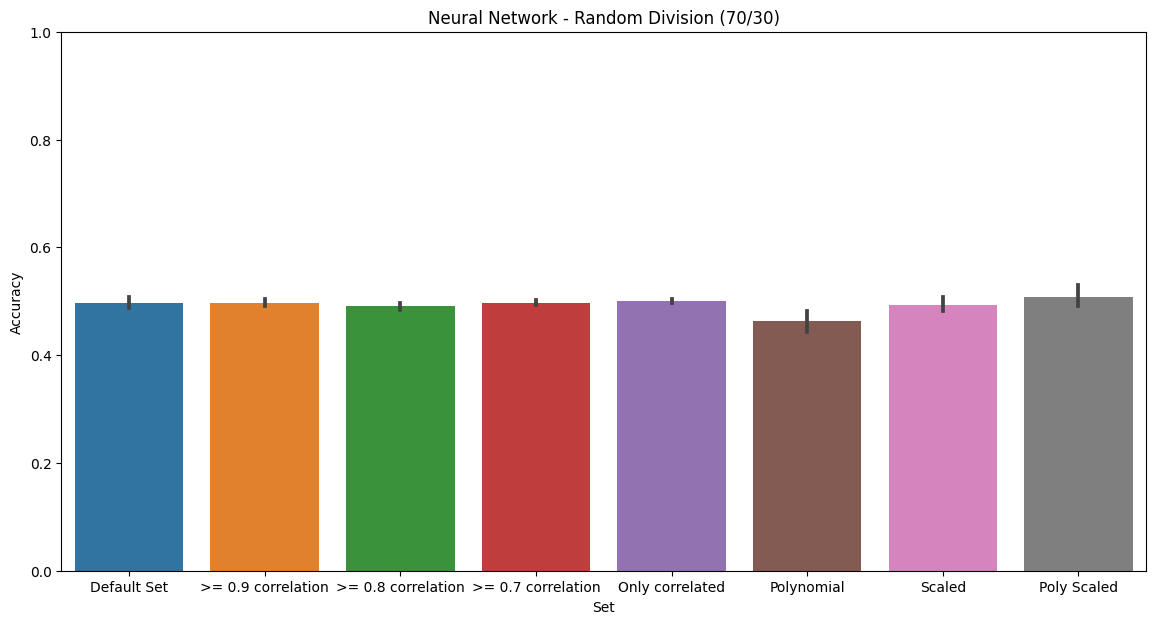

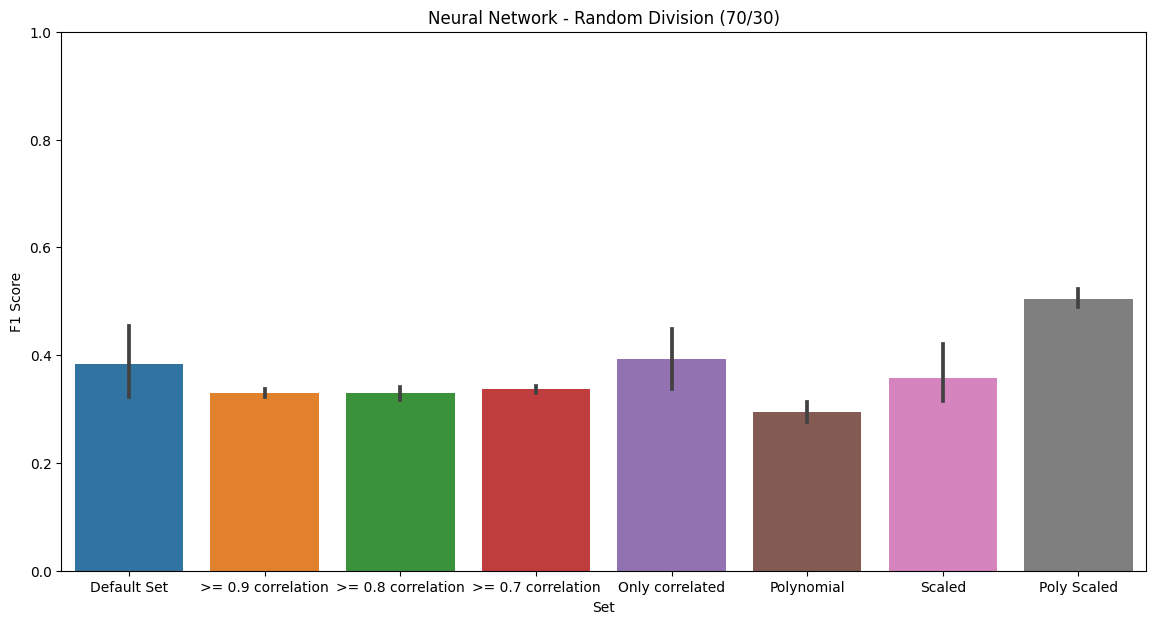

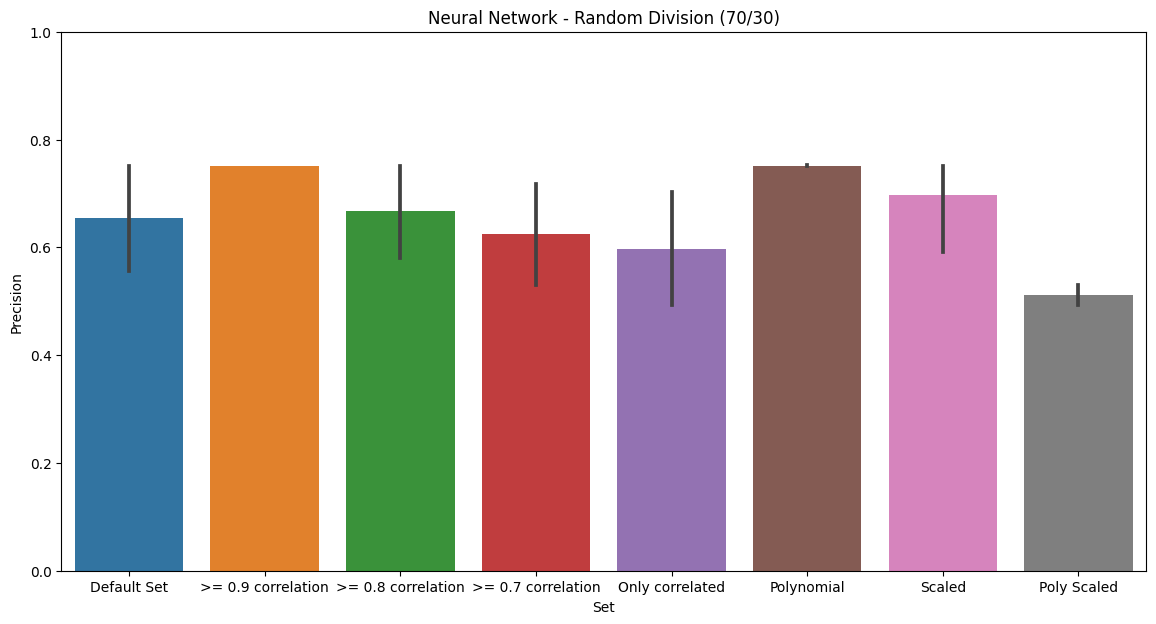

In [10]:
sets = {
    'Default Set': train_data,
    '>= 0.9 correlation': train_data_09,
    '>= 0.8 correlation': train_data_08,
    '>= 0.7 correlation': train_data_07,
    'Only correlated': train_data_nocorr,
    'Polynomial': train_data_poly,
    'Scaled': train_data_scaled,
    'Poly Scaled': train_data_poly_scaled
}


results = []

for (name, data_set) in sets.items():
    # Train the model
    for _ in range(5):  # running 5 times each
        neural_network = MLPClassifier(hidden_layer_sizes=(10, 20, 10), activation='logistic', solver='adam', alpha=0.0001, learning_rate_init=0.002)
        target_column = "is_claim"
        X = data_set.drop(target_column, axis=1)
        y = data_set[target_column]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        start_time = time.time()

        neural_network.fit(X_train, y_train)
        train_time = time.time() - start_time

        # Test the model
        start_time = time.time()
        y_pred = neural_network.predict(X_test)
        test_time = time.time() - start_time

        # Calculate evaluation metrics
        conf_matrix = confusion_matrix(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_test, y_pred, average='weighted')
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Store the results
        results.append({
            'Set': name,
            'Confusion Matrix': conf_matrix,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Train Time': train_time,
            'Test Time': test_time
        })
# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)
plt.figure(figsize=(14, 7))
plt.ylim(0, 1)
plt.title("Neural Network - Random Division (70/30)")
sb.barplot(x='Set', y='Accuracy', data=results_df)
plt.show()

plt.figure(figsize=(14, 7))
plt.ylim(0, 1)
plt.title("Neural Network - Random Division (70/30)")
sb.barplot(x='Set', y='F1 Score', data=results_df)
plt.show()

plt.figure(figsize=(14, 7))
plt.ylim(0, 1)
plt.title("Neural Network - Random Division (70/30)")
sb.barplot(x='Set', y='Precision', data=results_df)
plt.show()

C:\Users\andre\AI_Second\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andre\AI_Second\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andre\AI_Second\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andre\AI_Second\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andre\AI_Second\lib\site-packages\sklearn\neural_network\_multi

                   Set          Confusion Matrix  Precision    Recall   
0          Default Set      [[0, 787], [0, 713]]   0.750608  0.475333  \
1          Default Set      [[733, 0], [767, 0]]   0.750128  0.488667   
2          Default Set  [[546, 213], [530, 211]]   0.502597  0.504667   
3          Default Set      [[758, 0], [742, 0]]   0.750028  0.505333   
4          Default Set      [[769, 0], [731, 0]]   0.750160  0.512667   
5   >= 0.9 correlation      [[754, 0], [746, 0]]   0.750007  0.502667   
6   >= 0.9 correlation      [[711, 0], [789, 0]]   0.750676  0.474000   
7   >= 0.9 correlation      [[761, 0], [739, 0]]   0.750054  0.507333   
8   >= 0.9 correlation      [[0, 769], [0, 731]]   0.750160  0.487333   
9   >= 0.9 correlation      [[767, 0], [733, 0]]   0.750128  0.511333   
10  >= 0.8 correlation      [[717, 0], [783, 0]]   0.750484  0.478000   
11  >= 0.8 correlation  [[322, 435], [329, 414]]   0.491161  0.490667   
12  >= 0.8 correlation      [[0, 772], [0, 728]]   

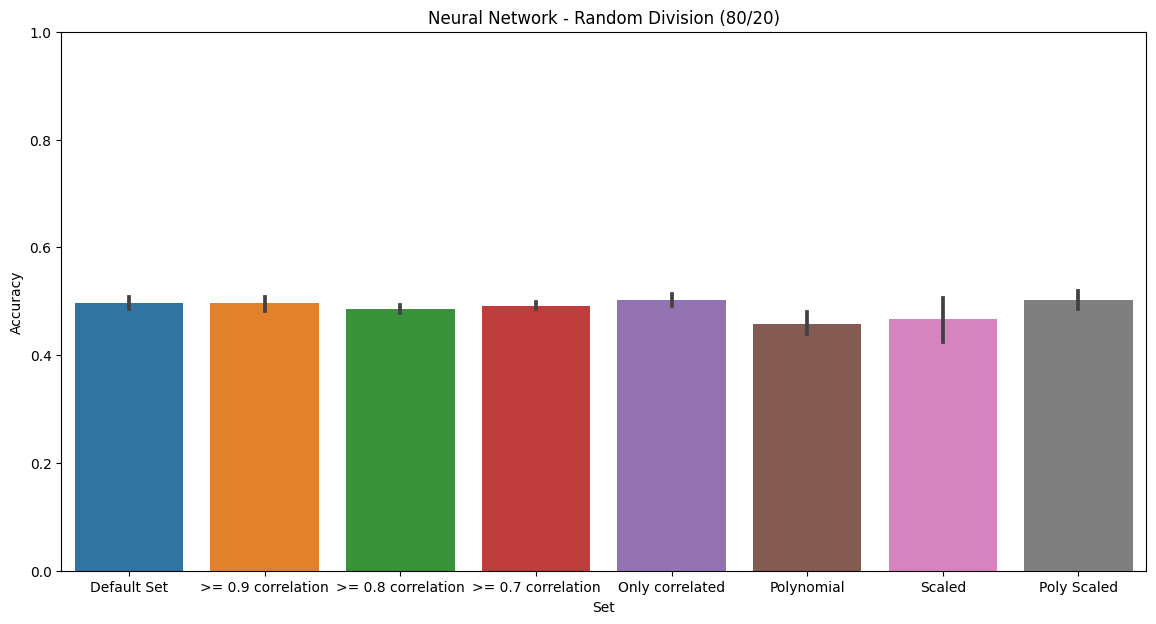

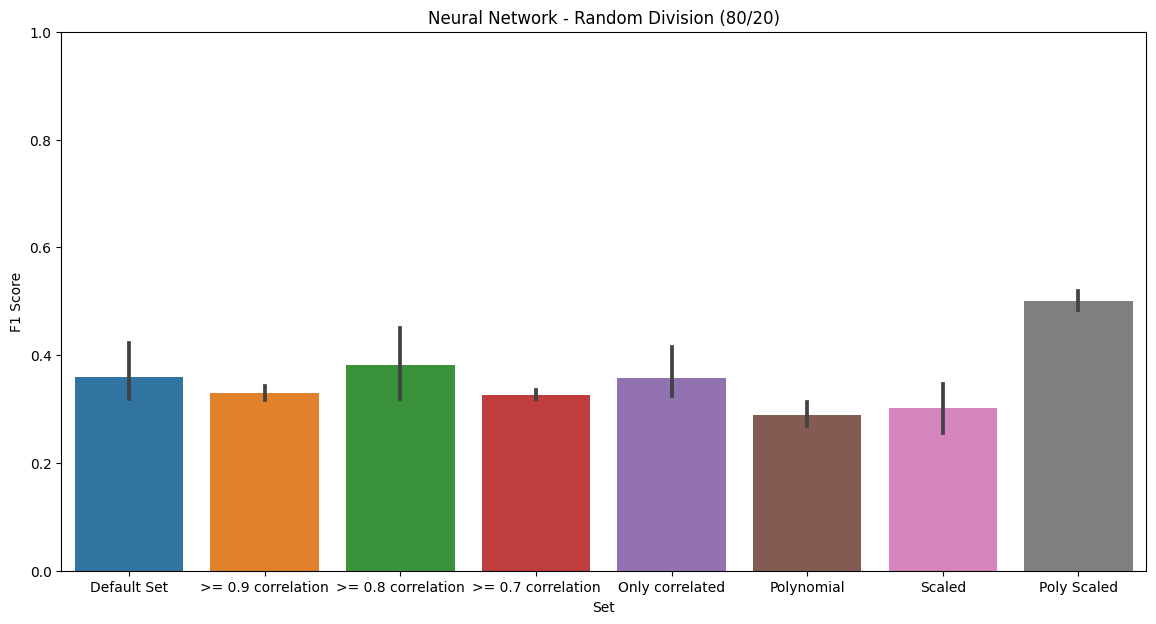

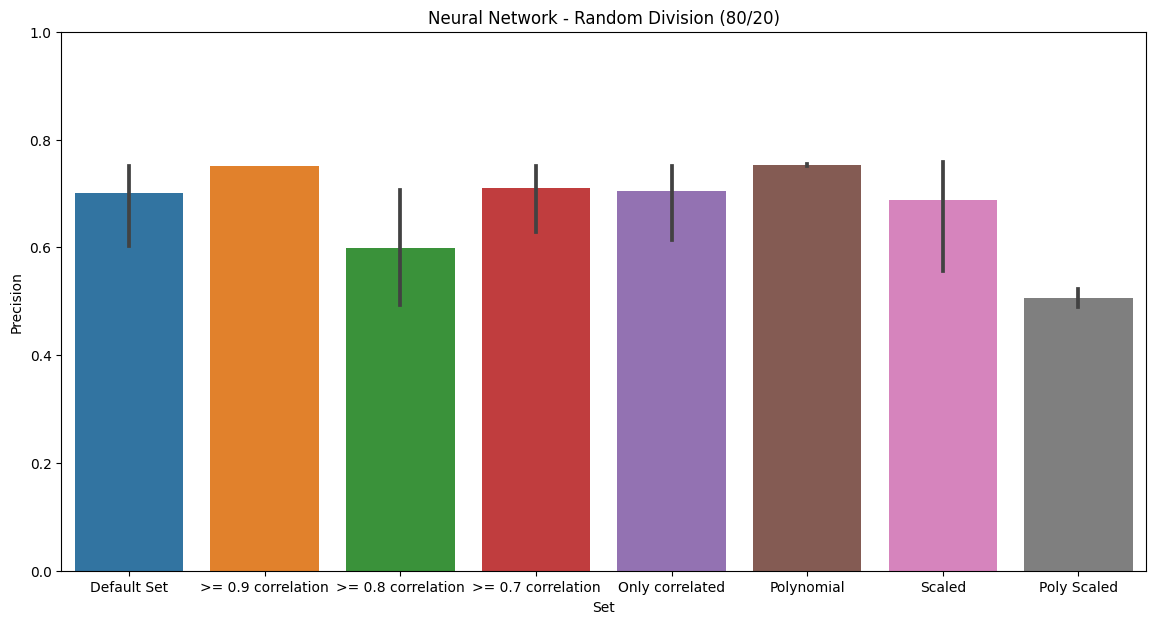

In [11]:
results = []

for (name, data_set) in sets.items():
    # Train the model
    for _ in range(5):  # running 5 times each
        neural_network = MLPClassifier(hidden_layer_sizes=(10, 20, 10), activation='logistic', solver='adam', alpha=0.0001, learning_rate_init=0.002)
        target_column = "is_claim"
        X = data_set.drop(target_column, axis=1)
        y = data_set[target_column]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        start_time = time.time()

        neural_network.fit(X_train, y_train)
        train_time = time.time() - start_time

        # Test the model
        start_time = time.time()
        y_pred = neural_network.predict(X_test)
        test_time = time.time() - start_time

        # Calculate evaluation metrics
        conf_matrix = confusion_matrix(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_test, y_pred, average='weighted')
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Store the results
        results.append({
            'Set': name,
            'Confusion Matrix': conf_matrix,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Train Time': train_time,
            'Test Time': test_time
        })
# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)
plt.figure(figsize=(14, 7))
plt.ylim(0, 1)
plt.title("Neural Network - Random Division (80/20)")
sb.barplot(x='Set', y='Accuracy', data=results_df)
plt.show()

plt.figure(figsize=(14, 7))
plt.ylim(0, 1)
plt.title("Neural Network - Random Division (80/20)")
sb.barplot(x='Set', y='F1 Score', data=results_df)
plt.show()

plt.figure(figsize=(14, 7))
plt.ylim(0, 1)
plt.title("Neural Network - Random Division (80/20)")
sb.barplot(x='Set', y='Precision', data=results_df)
plt.show()

C:\Users\andre\AI_Second\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\andre\AI_Second\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


                   Set          Confusion Matrix  Precision    Recall   
0          Default Set    [[1249, 0], [1250, 0]]   0.750000  0.499800  \
1          Default Set  [[941, 309], [916, 333]]   0.512709  0.509804   
2          Default Set    [[1249, 0], [1249, 0]]   0.750000  0.500000   
3   >= 0.9 correlation    [[0, 1249], [0, 1250]]   0.750000  0.500200   
4   >= 0.9 correlation  [[54, 1196], [41, 1208]]   0.535472  0.505002   
5   >= 0.9 correlation    [[1249, 0], [1249, 0]]   0.750000  0.500000   
6   >= 0.8 correlation  [[306, 943], [323, 927]]   0.491106  0.493397   
7   >= 0.8 correlation    [[1250, 0], [1249, 0]]   0.750000  0.500200   
8   >= 0.8 correlation    [[1249, 0], [1249, 0]]   0.750000  0.500000   
9   >= 0.7 correlation  [[26, 1223], [11, 1239]]   0.602936  0.506202   
10  >= 0.7 correlation  [[11, 1239], [15, 1234]]   0.461018  0.498199   
11  >= 0.7 correlation    [[1249, 0], [1249, 0]]   0.750000  0.500000   
12     Only correlated    [[0, 1249], [0, 1250]]   

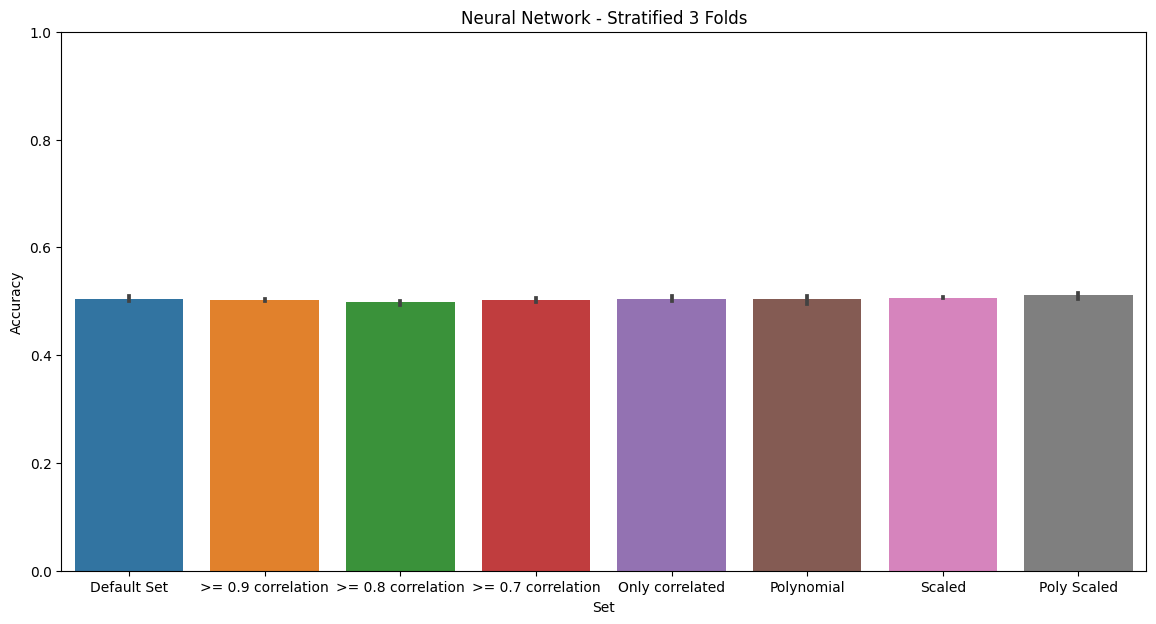

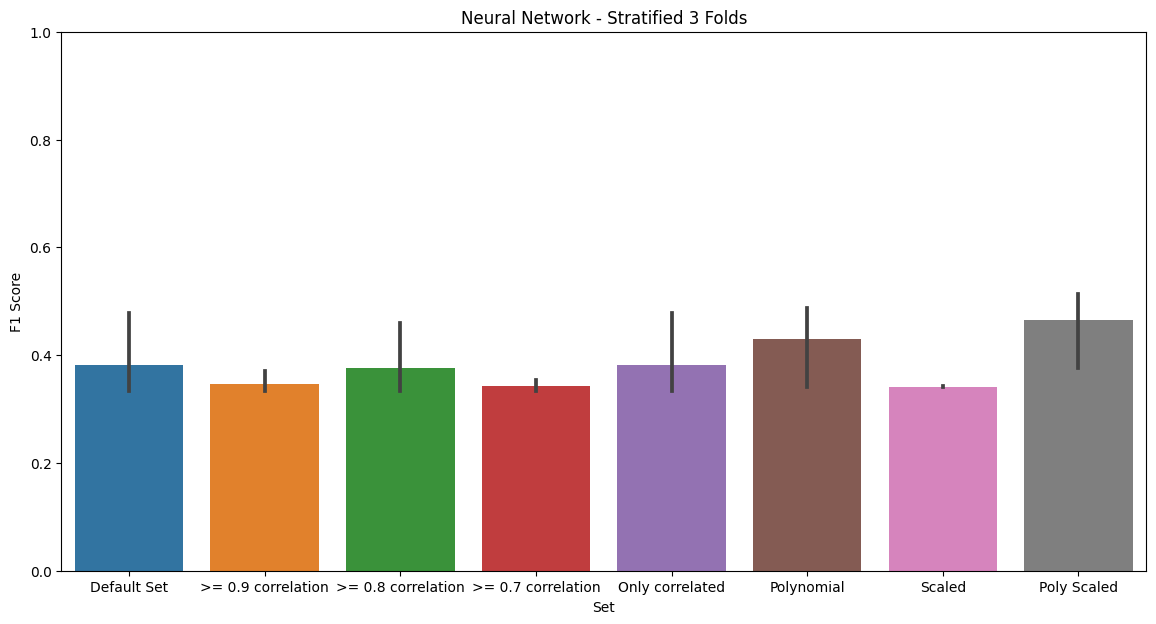

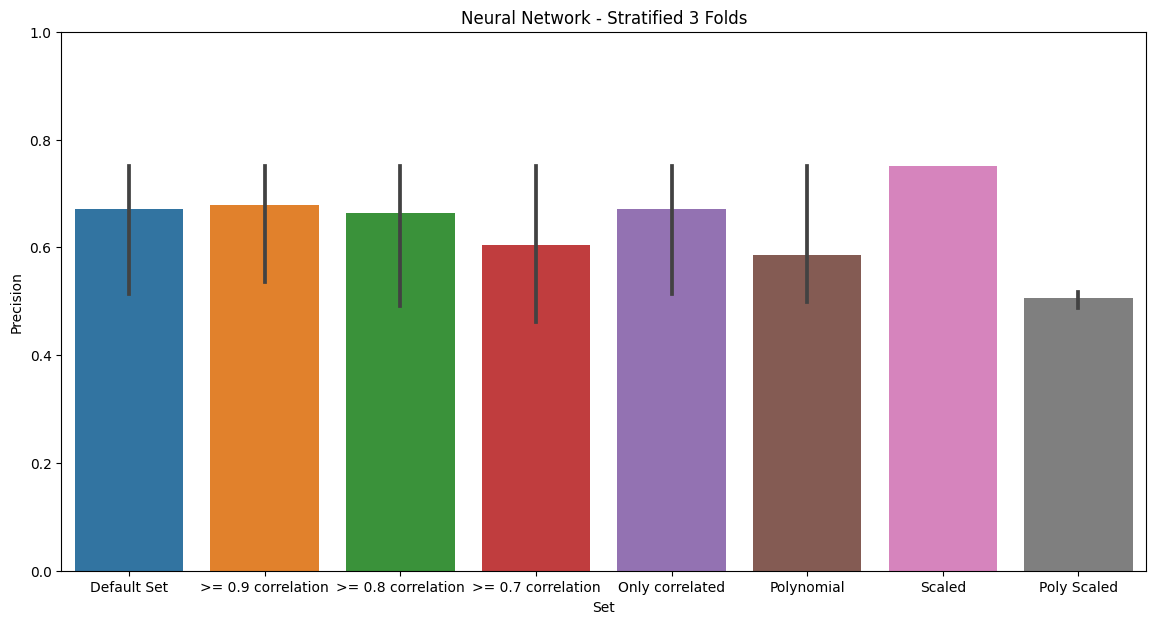

In [12]:
results = []
skf = StratifiedKFold(n_splits=3)

for (name, data_set) in sets.items():
    # Train the model
    neural_network = MLPClassifier(hidden_layer_sizes=(10, 20, 10), activation='logistic', solver='adam', alpha=0.0001, learning_rate_init=0.002)
    target_column = "is_claim"
    X = data_set.drop(target_column, axis=1)
    y = data_set[target_column]

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]

        start_time = time.time()
        neural_network.fit(X_train, y_train)
        train_time = time.time() - start_time

        # Test the model
        start_time = time.time()
        y_pred = neural_network.predict(X_test)
        test_time = time.time() - start_time

        # Calculate evaluation metrics
        conf_matrix = confusion_matrix(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_test, y_pred, average='weighted')
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Store the results
        results.append({
            'Set': name,
            'Confusion Matrix': conf_matrix,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Train Time': train_time,
            'Test Time': test_time
        })
# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)
plt.figure(figsize=(14, 7))
plt.ylim(0, 1)
plt.title("Neural Network - Stratified 3 Folds")
sb.barplot(x='Set', y='Accuracy', data=results_df)
plt.show()

plt.figure(figsize=(14, 7))
plt.ylim(0, 1)
plt.title("Neural Network - Stratified 3 Folds")
sb.barplot(x='Set', y='F1 Score', data=results_df)
plt.show()

plt.figure(figsize=(14, 7))
plt.ylim(0, 1)
plt.title("Neural Network - Stratified 3 Folds")
sb.barplot(x='Set', y='Precision', data=results_df)
plt.show()

We can conclude that the results didn't change much with the different sets and tweaks made in the neural network. Still, the `Only correlated` set performs well in the 80/20 random division (highest precision).

In the `Stratified 3 Fold` some sets are predicting only `Yes` and other ones only `No` depending on how the fold division is made.

There is still some possible work in the data to improve the overall results.

### Now we will use the GridSearchCV component of the sklearn package in order to find out the parameters combination that produces the best outcome for every classifier

### Furthermore, we also use some plots to make the comparison easier and more intuitive

In [10]:
#names = list(sets.keys())
#datasets = [sets[x] for x in names]
#target_column = "is_claim"
names = ['Train Data', 'Train Data 07', 'Train Data 08', 'Train Data 09', 'Only Correlated', 'Polynomial', 'Scaled', 'Poly Scaled']
datasets = [train_data, train_data_07, train_data_08, train_data_09, train_data_nocorr, train_data_poly, train_data_scaled, train_data_poly_scaled]
target_column = "is_claim"

In [11]:
from sklearn.model_selection import GridSearchCV


def grid_search_analysis(target, parameters, model, search_datasets, datasets_names):
    search_results = []
    for dataset in search_datasets:
        X = dataset.drop(target, axis=1)
        y = dataset[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        grid_search = GridSearchCV(model, param_grid=parameters, cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_params = grid_search.best_params_
        y_pred = grid_search.predict(X_test)
        print(best_params)

        conf_matrix_metrics = confusion_matrix(y_test, y_pred)
        precision_metrics = precision_score(y_test, y_pred, average='weighted', zero_division=1)
        recall_metrics = recall_score(y_test, y_pred, average='weighted')
        accuracy_metrics = accuracy_score(y_test, y_pred)
        f1_metrics = f1_score(y_test, y_pred, average='weighted')

        # Store the search_results
        search_results.append({
            'Confusion Matrix': conf_matrix_metrics,
            'Precision': precision_metrics,
            'Recall': recall_metrics,
            'Accuracy': accuracy_metrics,
            'F1 Score': f1_metrics,
        })
    for i, result in enumerate(search_results):
        # Create a heatmap of the confusion matrix
        sb.heatmap(result['Confusion Matrix'], annot=True, cmap='Blues')

        # Add labels and title to the plot
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.title(f'Confusion Matrix for ' + datasets_names[i])

        # Show the plot
        plt.show()
    metrics = ['Precision', 'Recall', 'Accuracy', 'F1 Score']
    for metric in metrics:
        # Extract the metric values for each dataset
        values = [result[metric] for result in search_results]

        # Add labels and title to the plot
        plt.figure(figsize=(14, 7))
        plt.ylim(0, 1)
        plt.xlabel('Dataset')
        plt.ylabel(metric)
        plt.title(f'{metric} comparison across search_datasets')
        # Create a bar plot to compare the metric values
        sb.barplot(x=datasets_names, y=values)
        # Show the plot
        plt.show()

### Neural Network

Regarding the Neural Network model:

{'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'adaptive', 'max_iter': 200, 'solver': 'sgd'}
{'activation': 'tanh', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 200, 'solver': 'adam'}
{'activation': 'tanh', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (50, 100), 'learning_rate': 'adaptive', 'max_iter': 600, 'solver': 'sgd'}
{'activation': 'tanh', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'adaptive', 'max_iter': 200, 'solver': 'sgd'}
{'activation': 'tanh', 'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (50, 100), 'learning_rate': 'constant', 'max_iter': 400, 'solver': 'sgd'}
{'activation': 'tanh', 'alpha': 0.001, 'early_stopping': False, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 200, 'solver': 'adam'}
{'activation': 'tanh', 'alpha': 0.0001, 'early

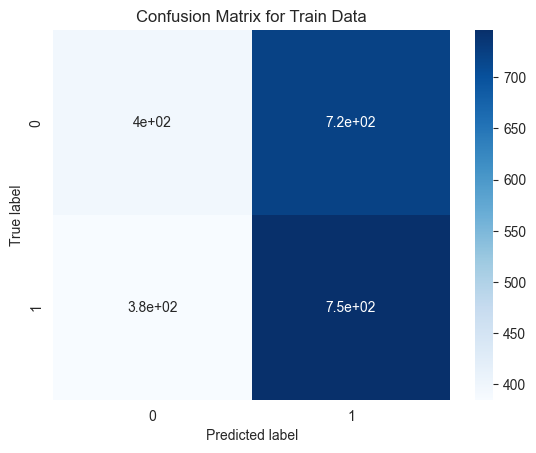

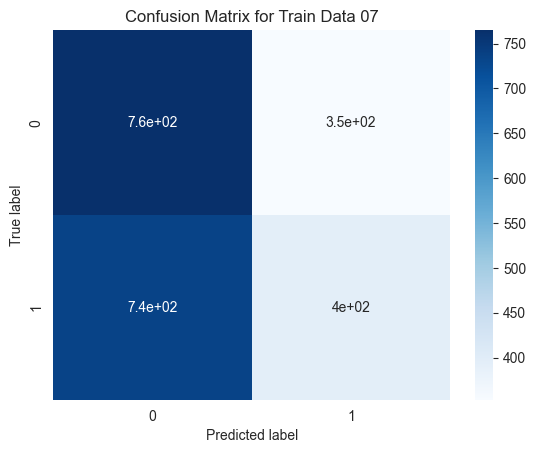

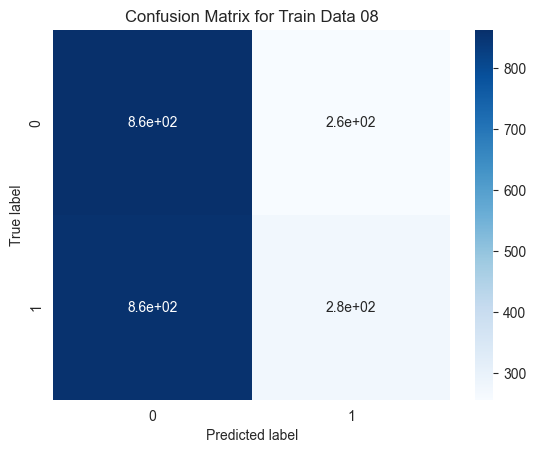

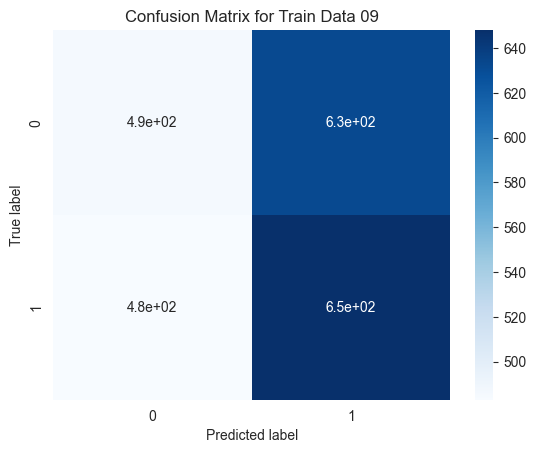

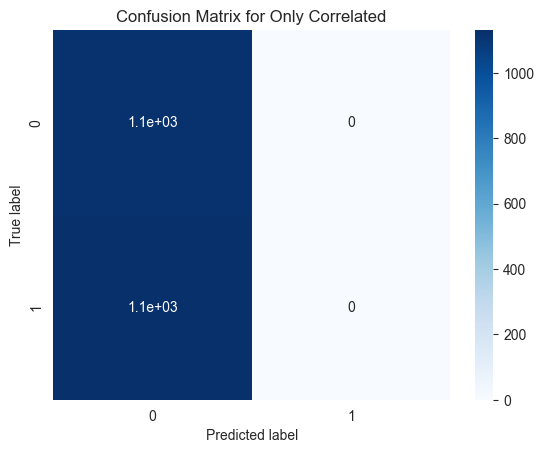

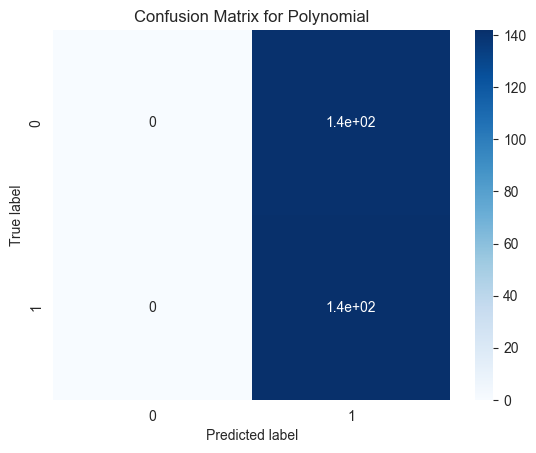

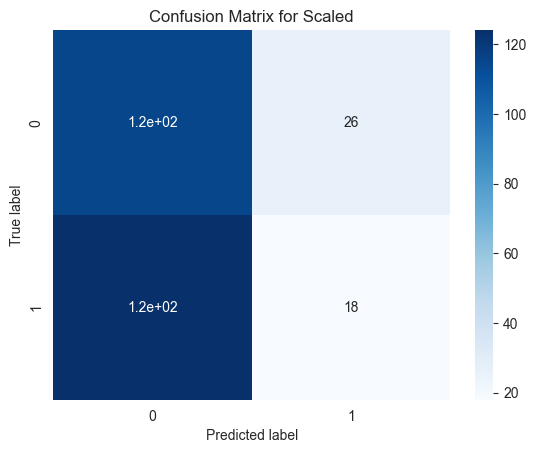

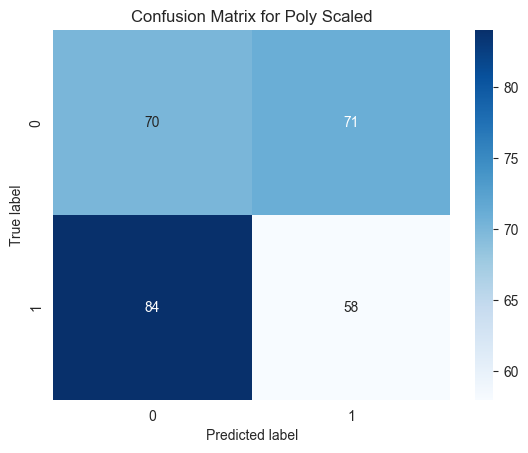

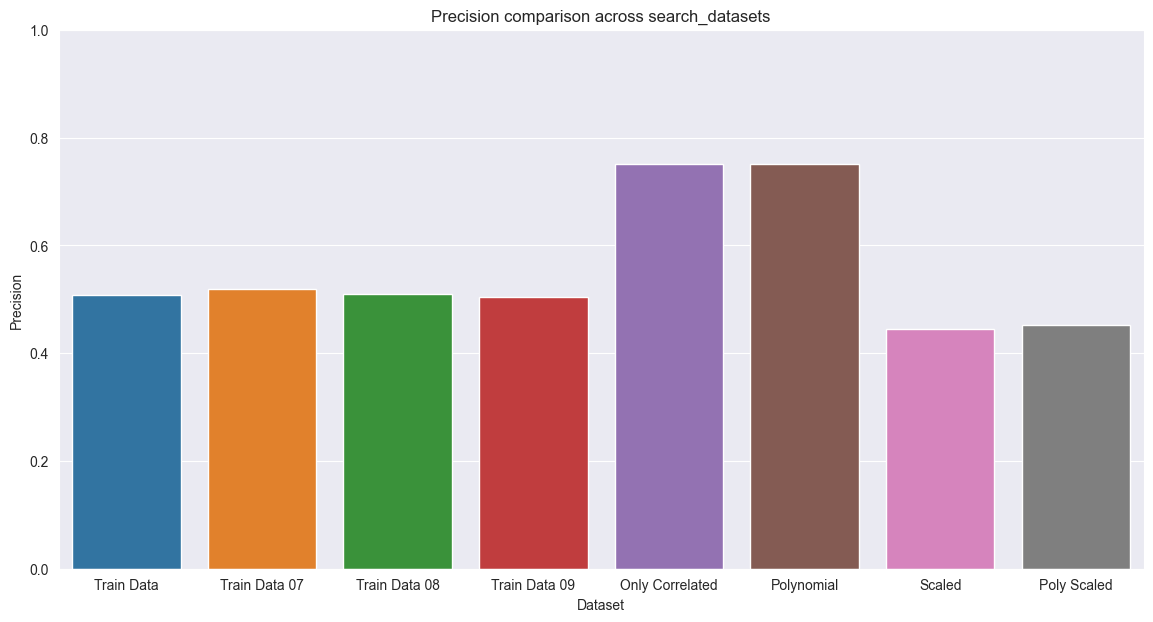

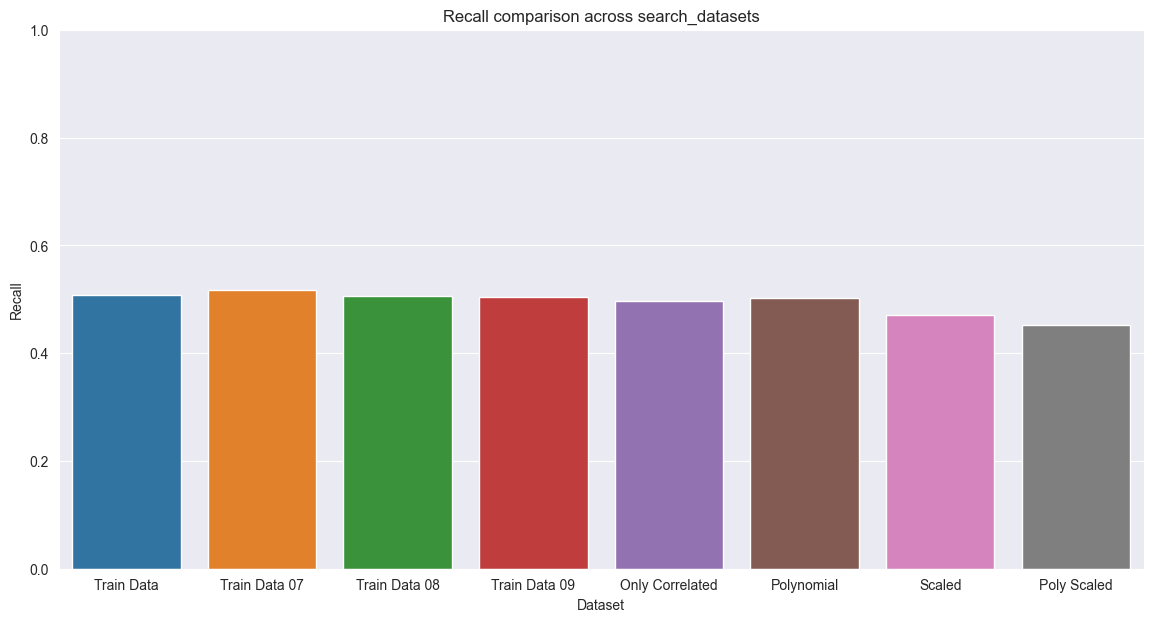

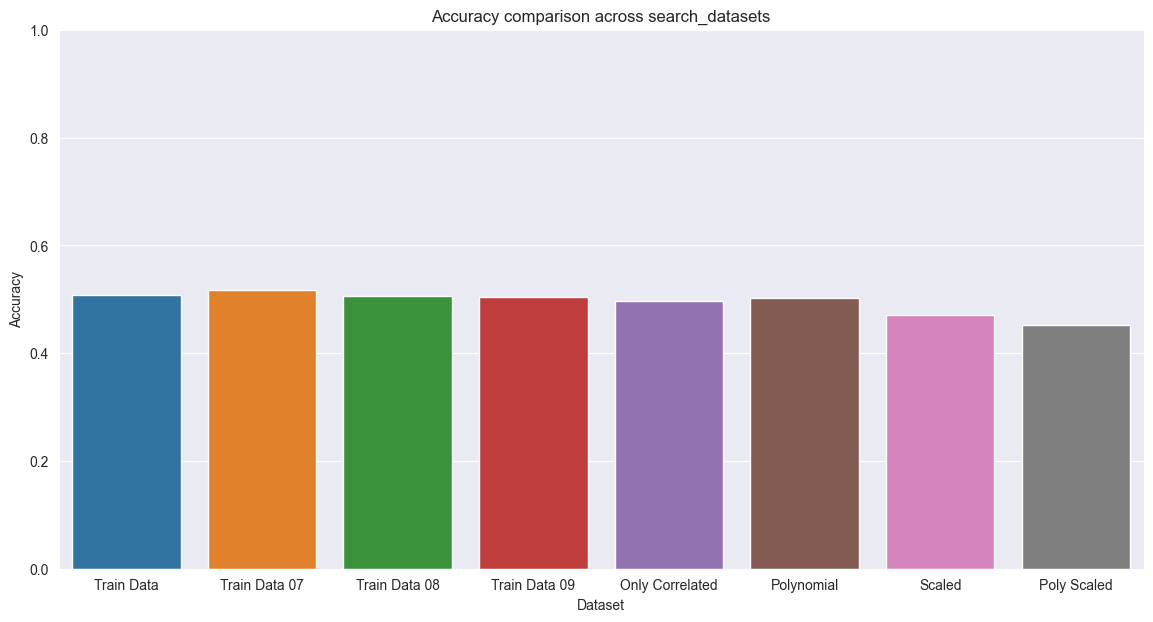

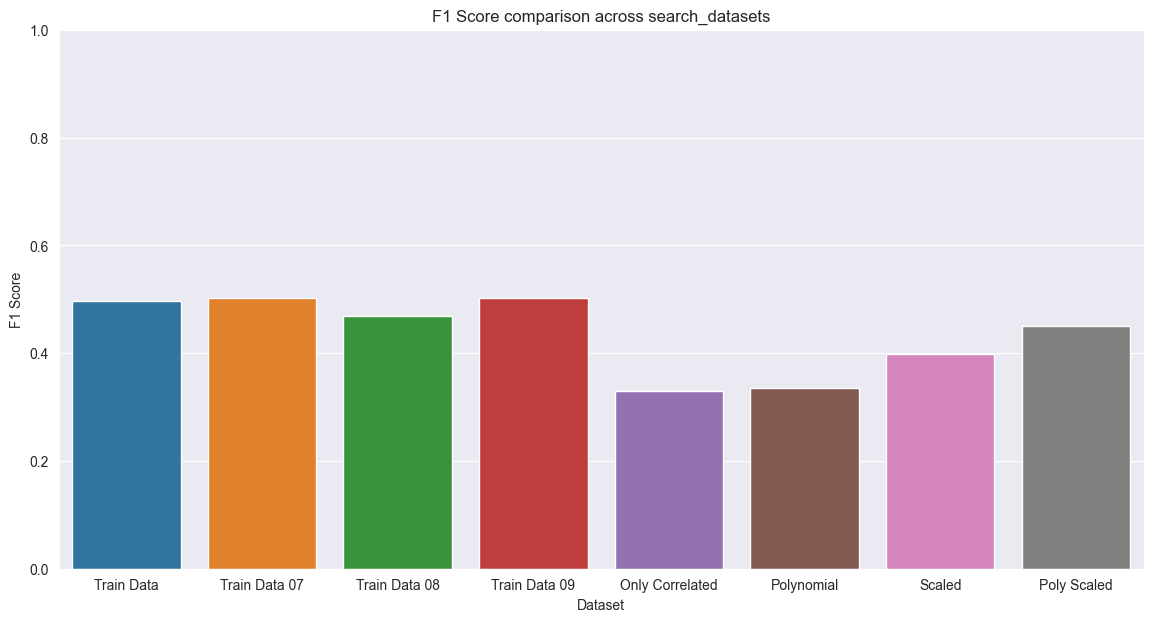

In [18]:
params = {
    'hidden_layer_sizes': [(100,), (50, 100), (50, 50, 100), (100, 100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [200, 400, 600],
    'early_stopping': [True, False]
}

grid_search_analysis(target_column, params, MLPClassifier(), datasets, names)

The results indicate that the Neural Network model performed the worst overall. Though the accuracies were similar across the datasets, the precision was higher for `Only Correlated` and `Polinomial` because they only predicted one option [`Yes`, `No`].

The optimal parameters differed greatly. One thing we can note is that we would expect the activation function to be `logistic` or `relu` for a classification problem since they are the most common. However, some models preferred `tanh` activation.

### Decision Tree

Regarding the Decision Tree model:

{'criterion': 'entropy', 'max_depth': 320, 'max_features': 37, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'splitter': 'best'}
{'criterion': 'gini', 'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 0.1, 'min_samples_split': 0.5, 'splitter': 'best'}
{'criterion': 'entropy', 'max_depth': 160, 'max_features': 7, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'splitter': 'best'}
{'criterion': 'gini', 'max_depth': 320, 'max_features': 9, 'min_samples_leaf': 0.1, 'min_samples_split': 0.5, 'splitter': 'best'}
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 0.1, 'min_samples_split': 0.5, 'splitter': 'best'}
{'criterion': 'entropy', 'max_depth': 640, 'max_features': 41, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'splitter': 'random'}
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 24, 'min_samples_leaf': 0.3, 'min_samples_split': 0.7, 'splitter': 'random'}
{'criterion': 'entropy', 'max_depth': 640, 'max_features': 31, 'min_samp

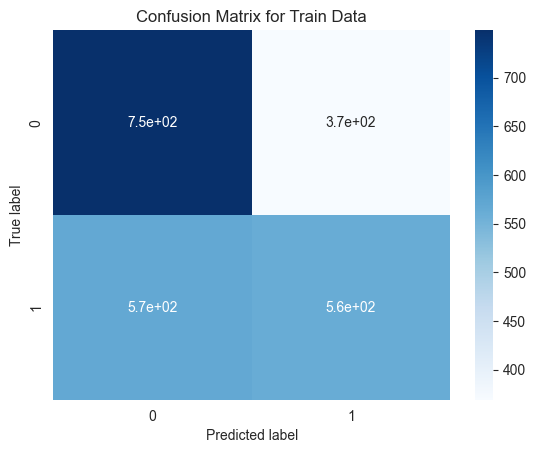

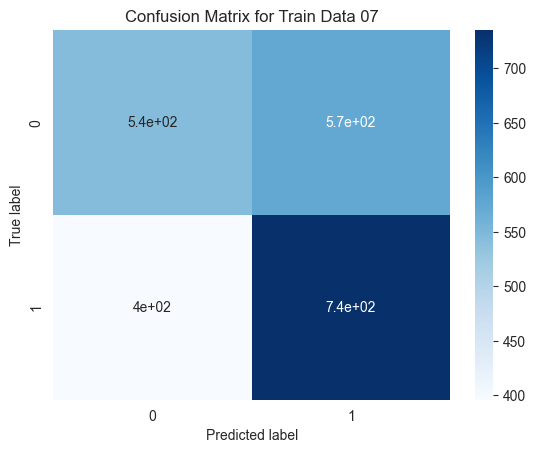

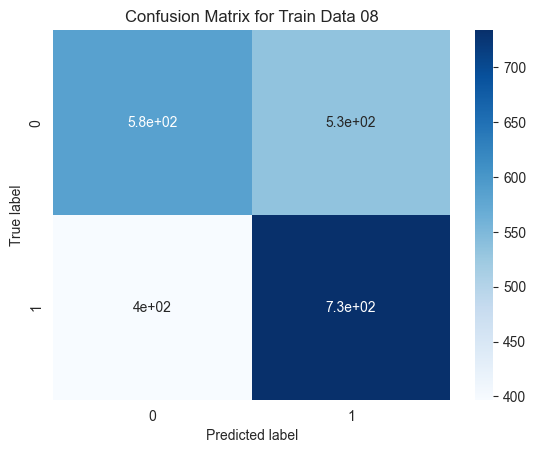

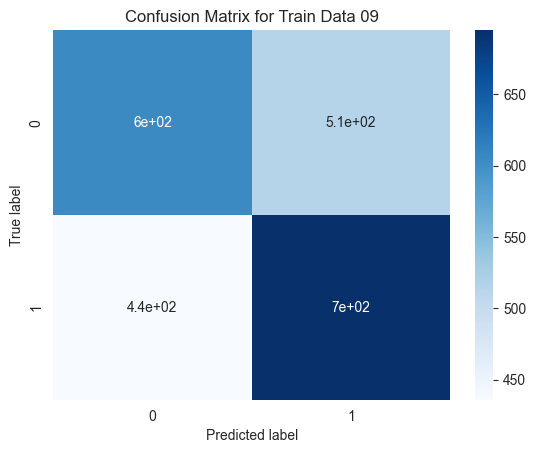

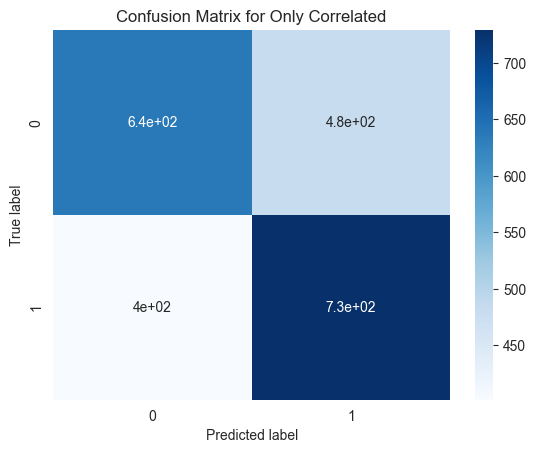

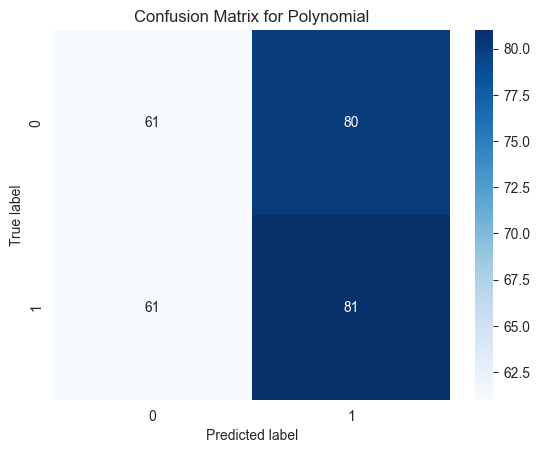

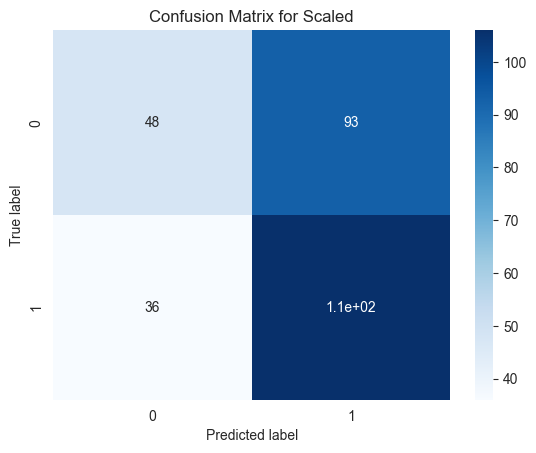

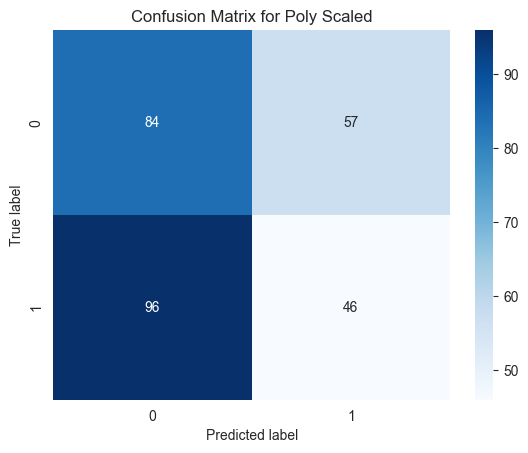

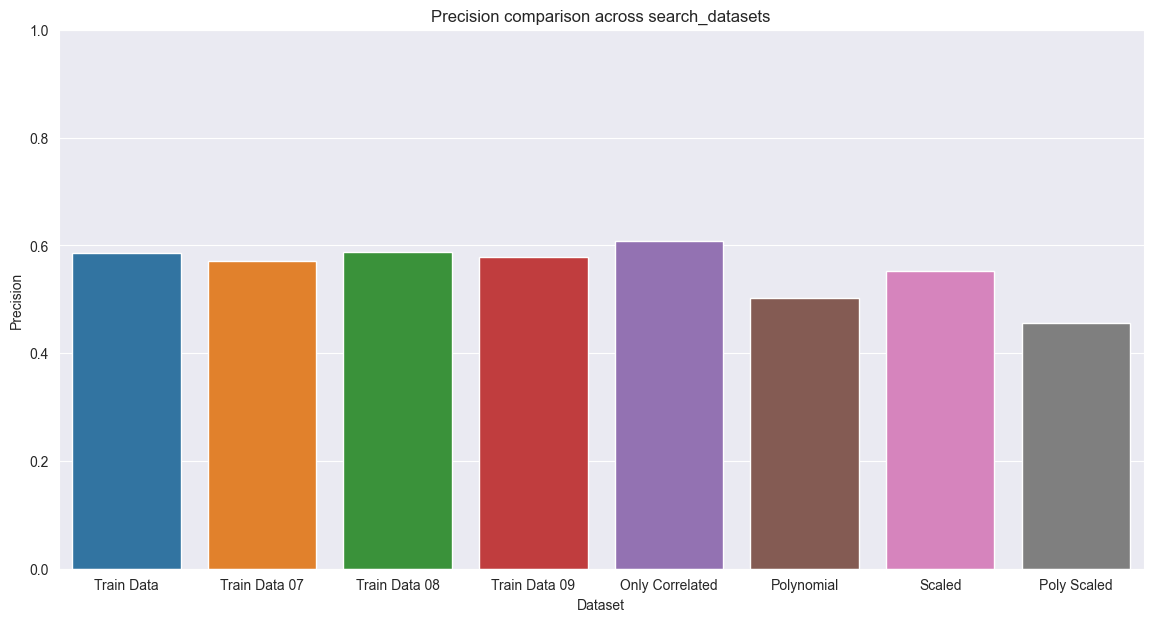

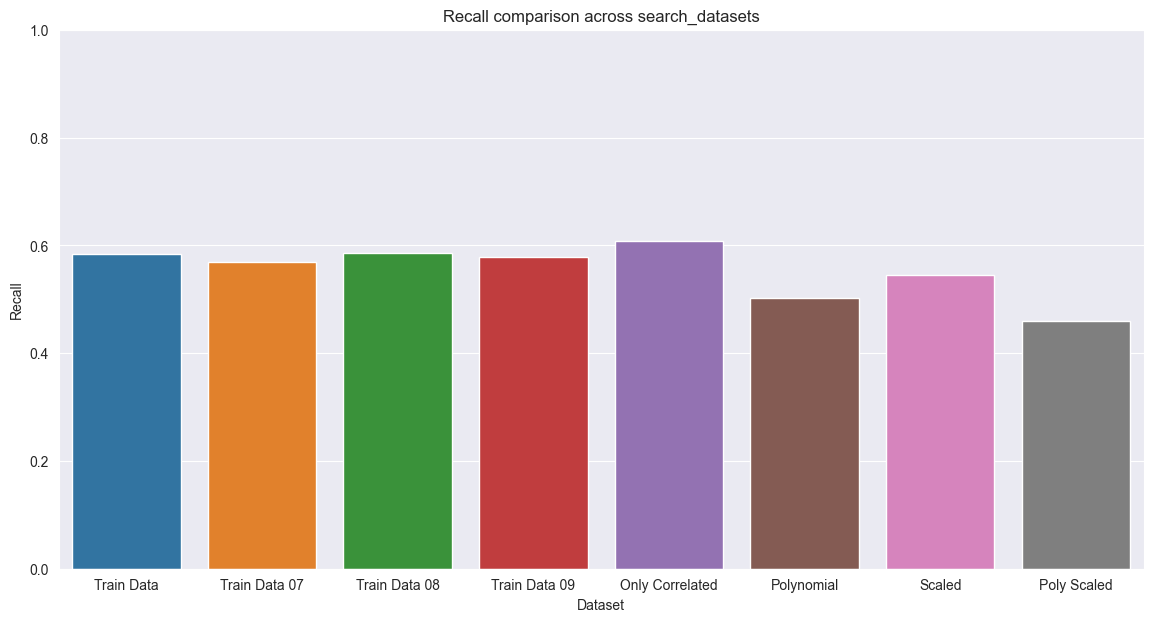

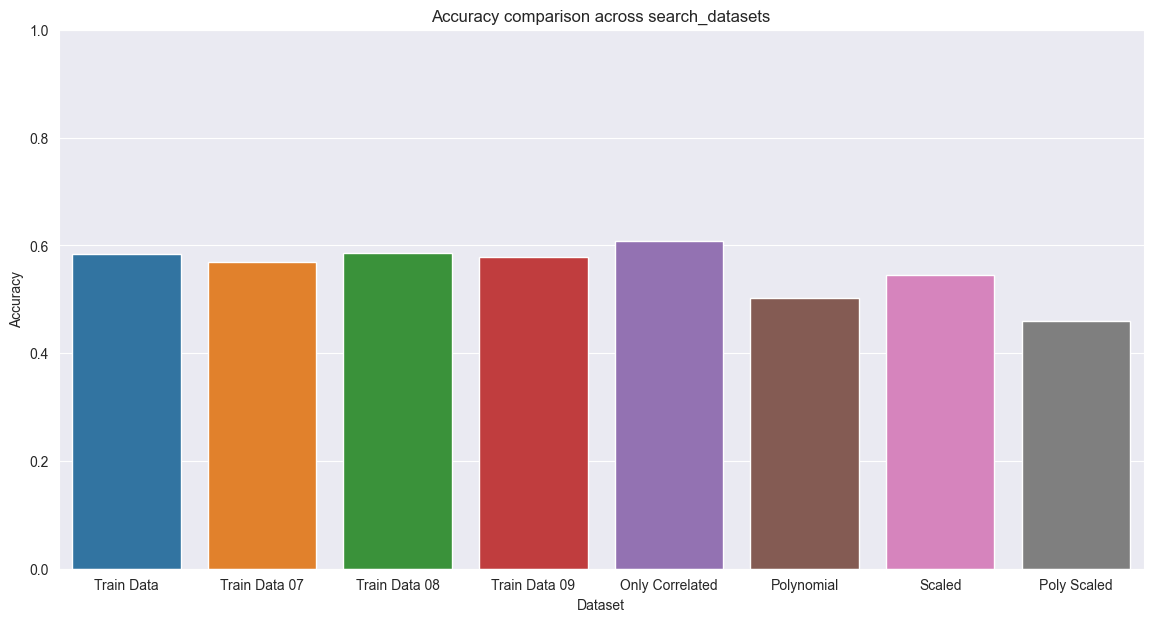

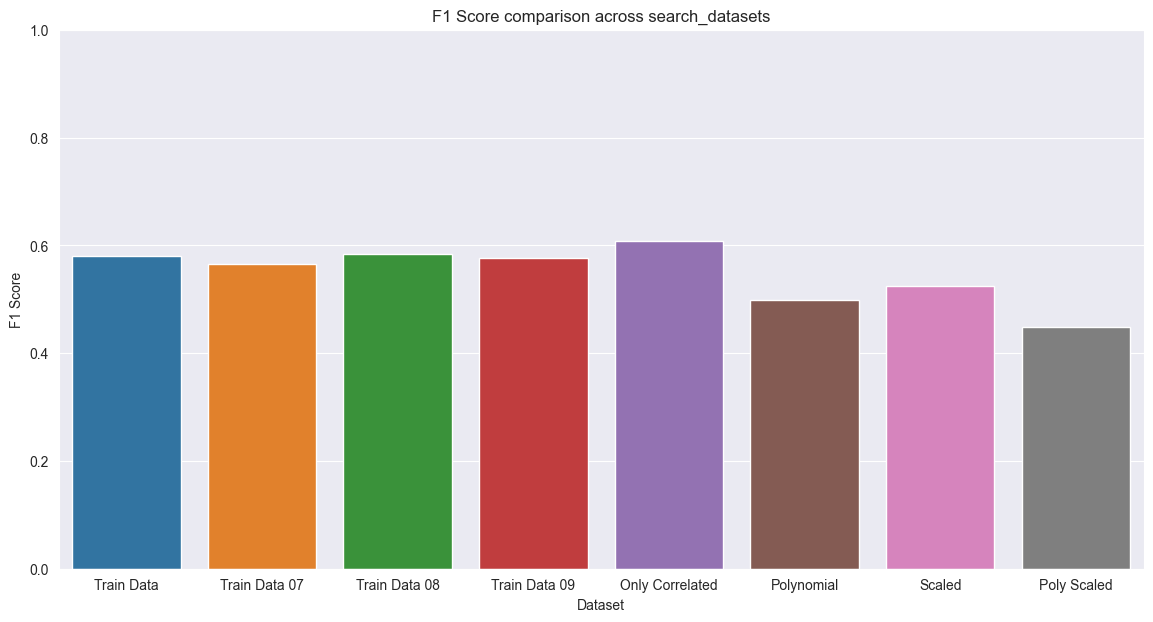

In [20]:
params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [5, 10, 20, 80, 160, 320, 640, None],
    'min_samples_split': [0.1, 0.3, 0.5, 0.7, 0.9],
    'min_samples_leaf': [0.1, 0.3, 0.5, 0.7, 0.9],
    'max_features': [None] + [x for x in range(1, len(train_data.columns))]
}
grid_search_analysis(target_column, params, DecisionTreeClassifier(), datasets, names)
# Best params results:
# {'criterion': 'entropy', 'max_depth': 20, 'max_features': 32, 'min_samples_leaf': 0.1, 'min_samples_split': 0.5, 'splitter': 'best'}
# {'criterion': 'entropy', 'max_depth': 20, 'max_features': 3, 'min_samples_leaf': 0.1, 'min_samples_split': 0.6, 'splitter': 'best'}
# {'criterion': 'entropy', 'max_depth': 640, 'max_features': 5, 'min_samples_leaf': 0.1, 'min_samples_split': 0.6, 'splitter': 'best'}
# {'criterion': 'gini', 'max_depth': 10, 'max_features': 6, 'min_samples_leaf': 0.1, 'min_samples_split': 0.2, 'splitter': 'best'}

Based on the results obtained, the best set is the `Only Correlated`. It performs better in every graph.

Looking at the `criterion` parameter, the dataset could select between `Gini` and `Entropy`.
This selection would depend on the amount of impurities that are present in the data. For example, the `Only correlated` set should select the `Entropy` criterion, which is more concerned with the amount of information gained from a split, and it happens as expected.

The `Train Data 07` should select the `Gini` critetion, which is appropriate given the presence of numerous irrelevant features, happening again as expected.

The remaining parameters are primarily influenced by the size of the data sets. The default set, which is larger, requires more search and hence more computational resources. In contrast, the smaller 70% data set does not require as much computational effort as it has fewer data.

### K-Nearest Neighbors

Regarding the K-Nearest Neighbors model:

{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'chebyshev', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
{'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'chebyshev', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
{'algorithm': 'kd_tree', 'leaf_size': 20, 'metric': 'chebyshev', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}


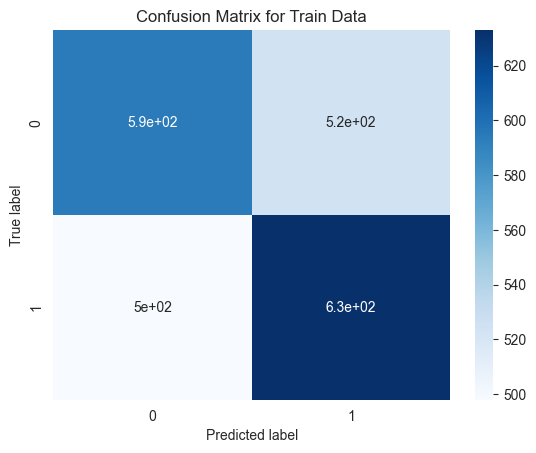

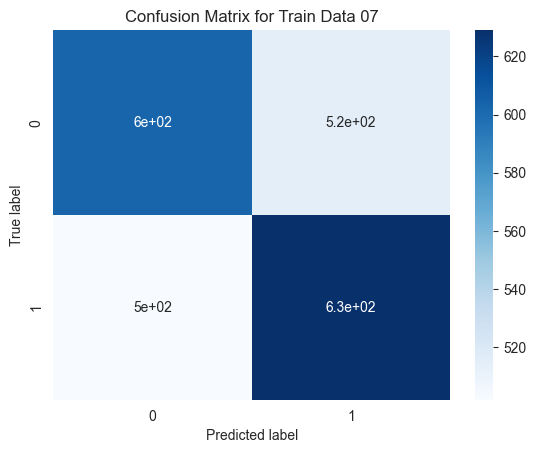

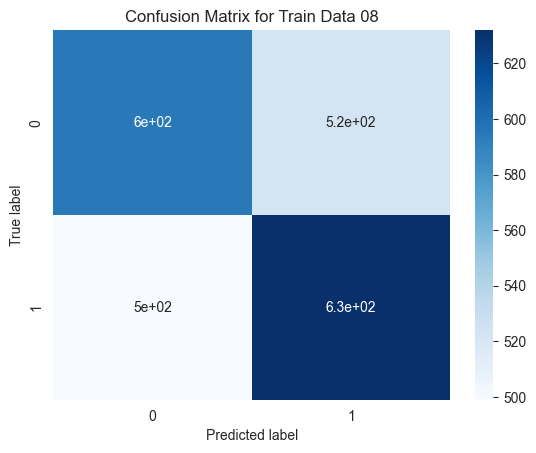

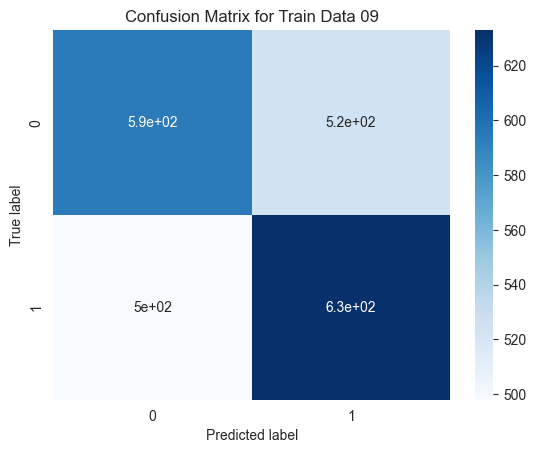

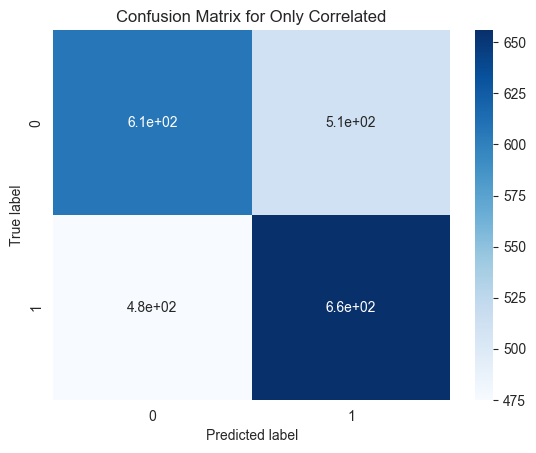

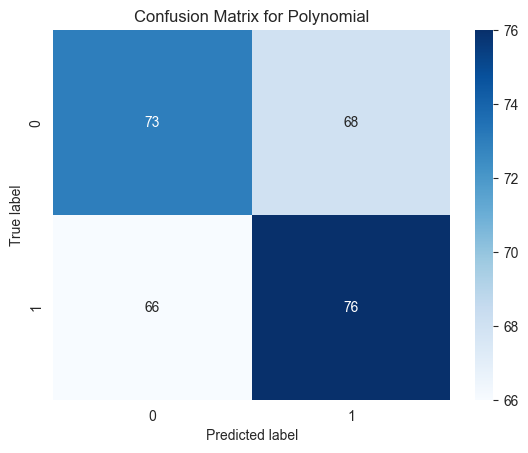

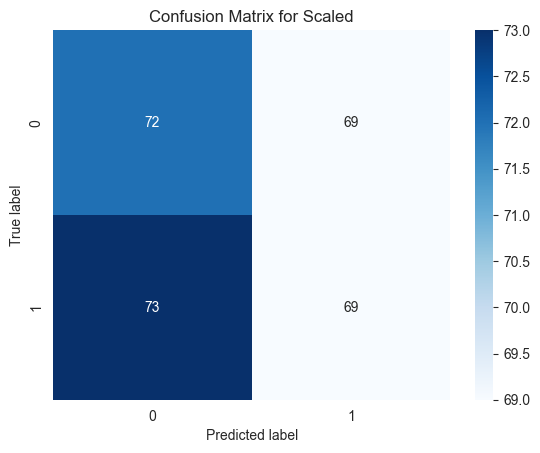

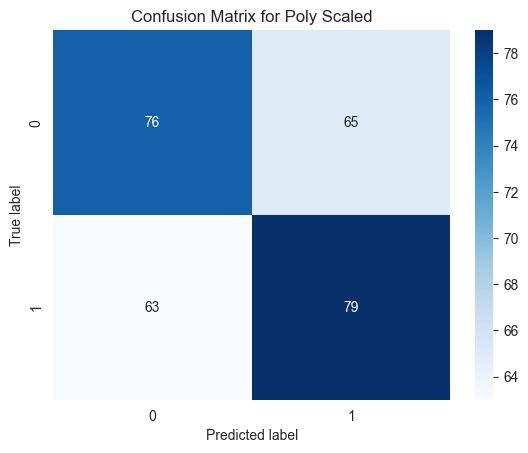

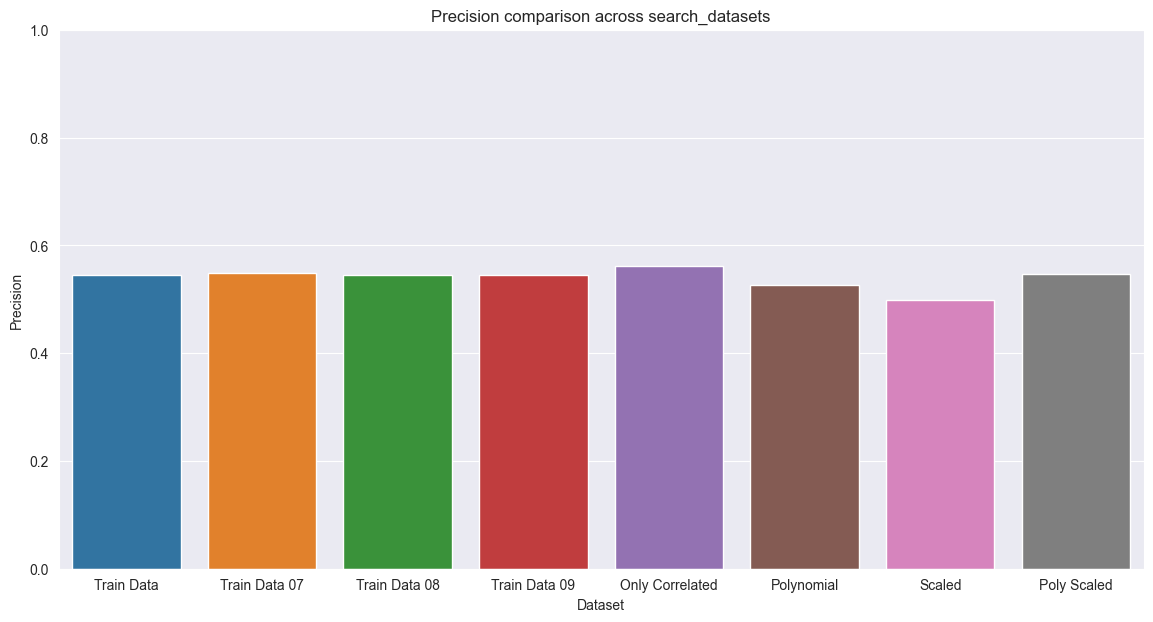

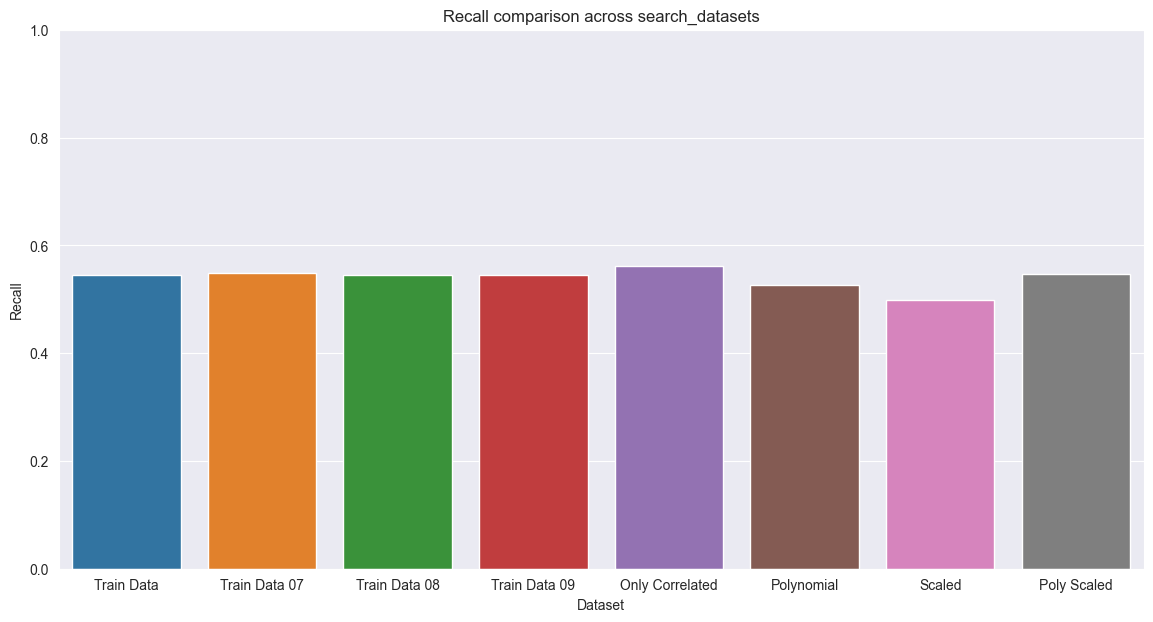

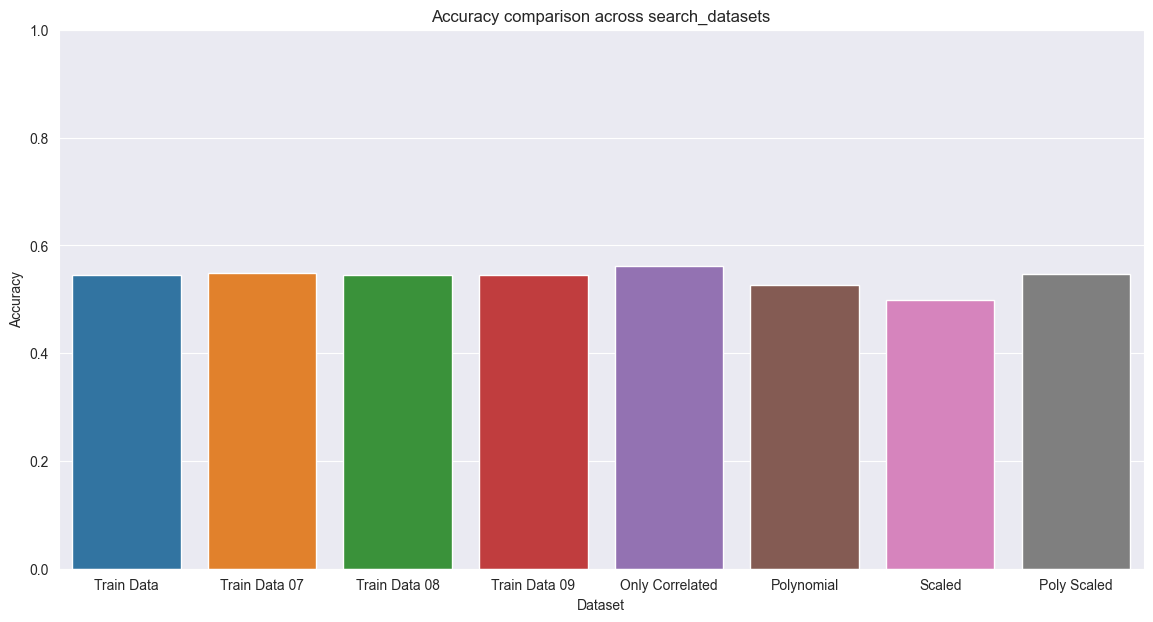

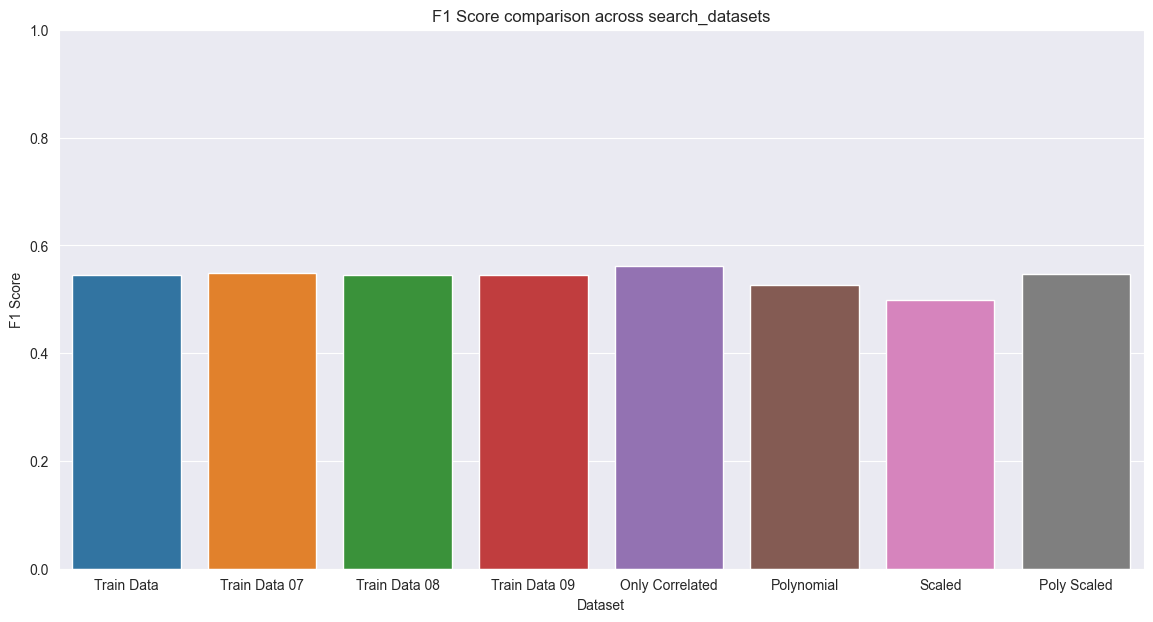

In [14]:
params = {
    'n_neighbors': [1, 3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50],
    'p': [1, 2],
    'metric': ['euclidean', 'manhattan', 'chebyshev']
}

grid_search_analysis(target_column, params, KNeighborsClassifier(), datasets, names)

The results are largely consistent across data sets (the `Polynomial`, `Scaled` and `Poly Scaled` datasets perform the worst).

Looking at the selected parameters:
- The algorithm is typically set to `auto` since it chooses the optimal algorithm. However, `kd_tree` may be the best choice here given the moderate data size (6000 rows).
- The `distance` weight is preferred for all data sets, indicating the data is not **evenly distributed**.
- The metric depends on the data distribution but is primarily `manhattan`, suggesting the values have distances which they want to emphasize more than others.

### Support Vector Machine

Regarding the Support Vector Machine model:

C:\Users\andre\AI_Second\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


{'C': 10, 'coef0': 3, 'decision_function_shape': 'ovr', 'degree': 4, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': 25000, 'shrinking': False, 'tol': 0.001}
{'C': 100, 'coef0': 3, 'decision_function_shape': 'ovr', 'degree': 2, 'gamma': 'auto', 'kernel': 'sigmoid', 'max_iter': 1000, 'shrinking': True, 'tol': 0.0001}


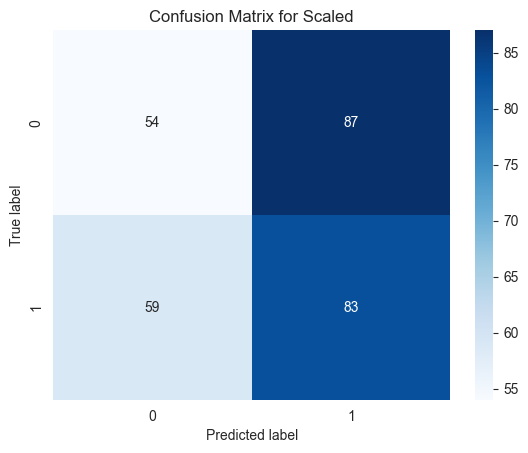

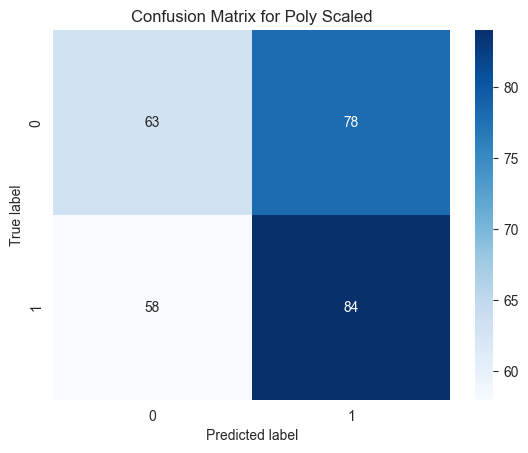

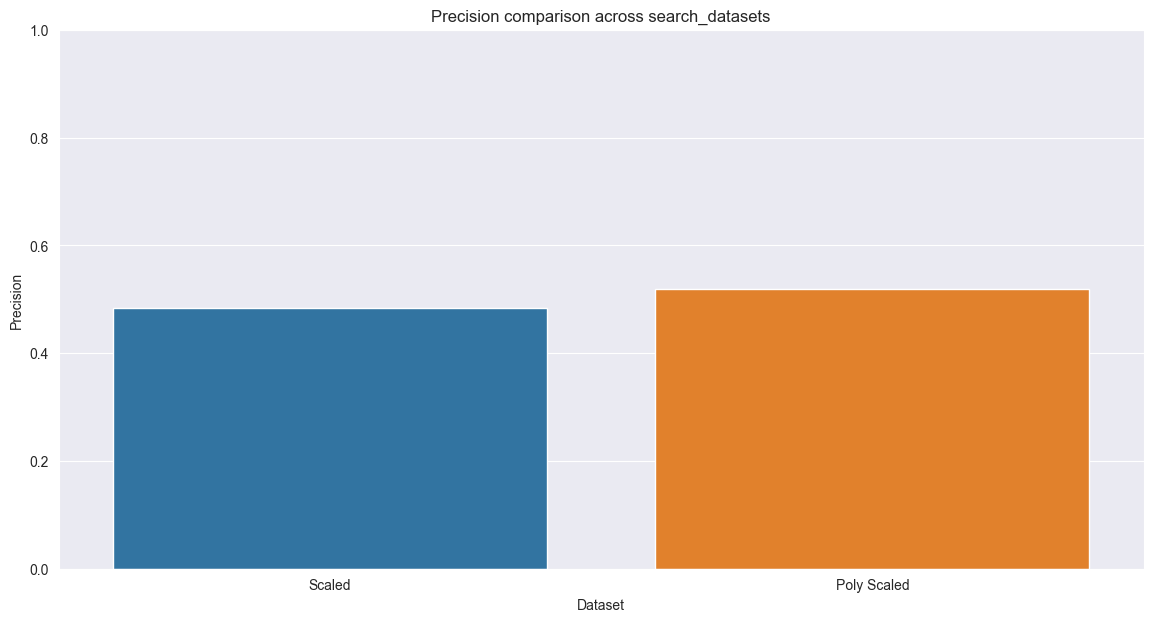

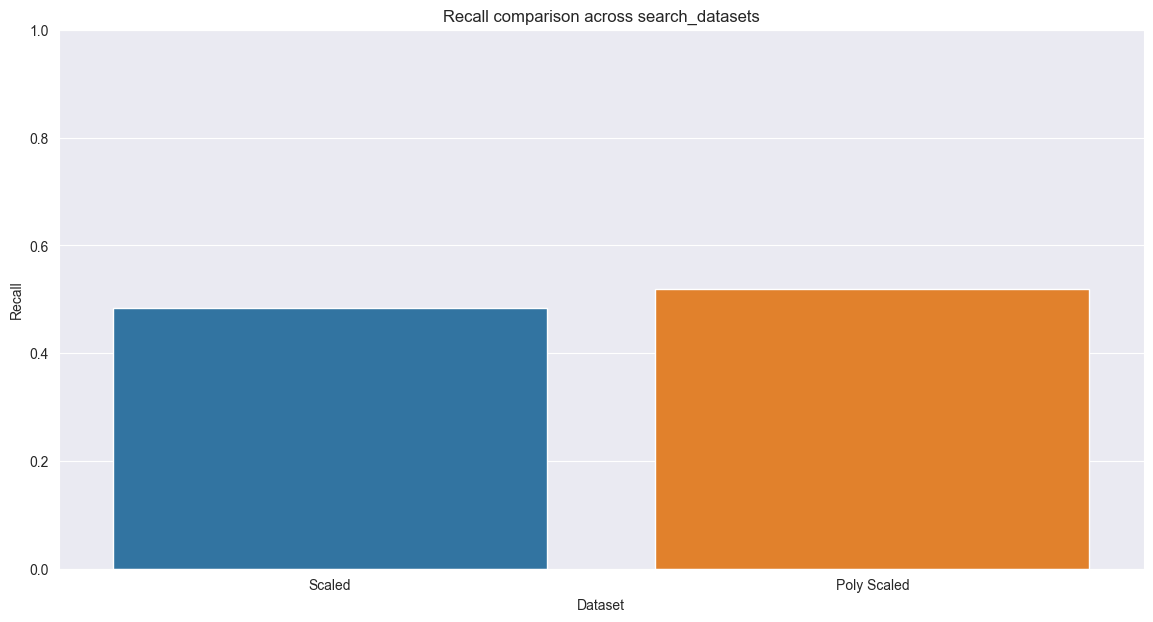

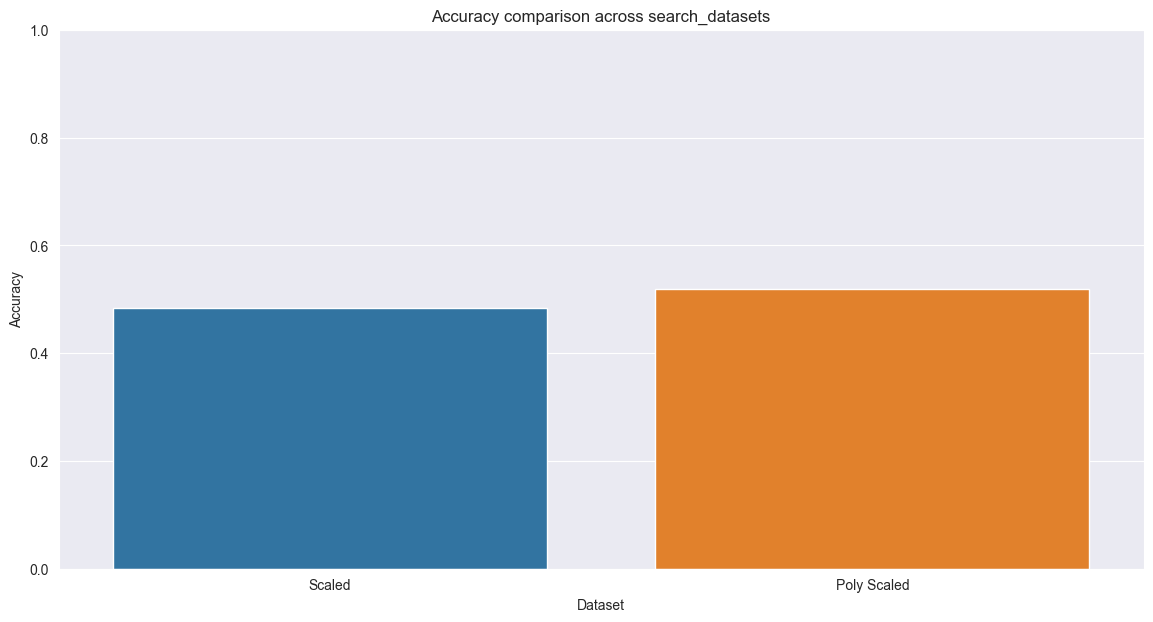

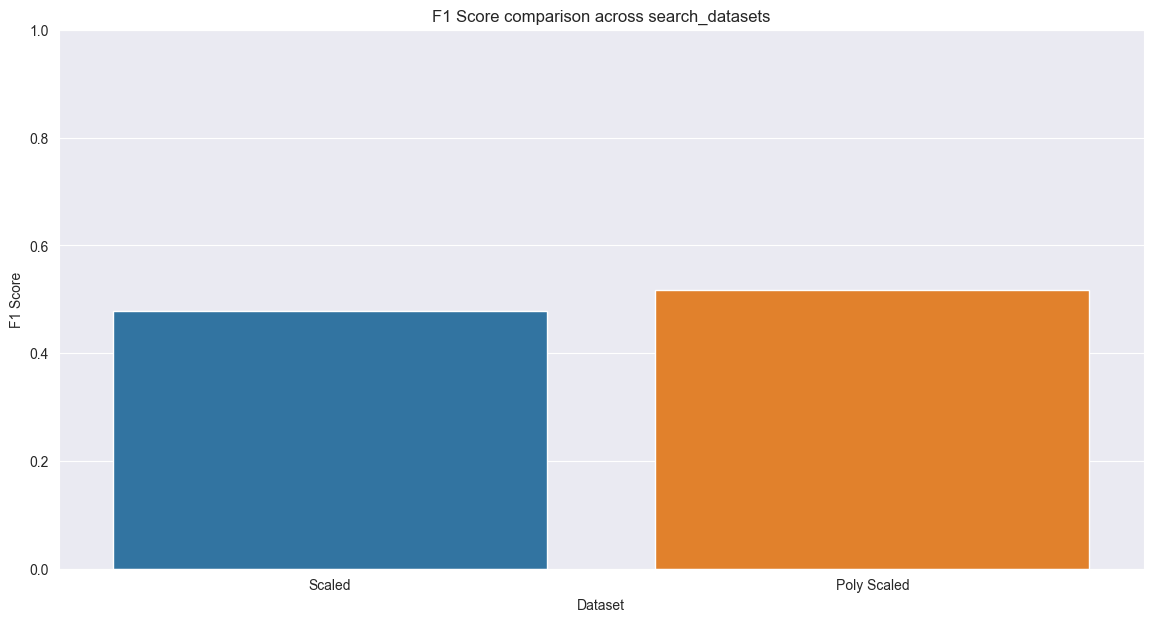

In [17]:
params = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4, 5],
    'gamma': ['scale', 'auto'],
    'coef0': [0, 1, 2, 3],
    'shrinking': [True, False],
    'tol': [1e-3, 1e-4, 1e-5],
    'max_iter': [1000, 2000, 25000],
    'decision_function_shape': ['ovr', 'ovo']
}

grid_search_analysis(target_column, params, SVC(), [train_data_scaled, train_data_poly_scaled], ['Scaled', 'Poly Scaled'])

Because of the complexity of the SVM algorithm, we could only test in the scaled datasets.

They performed equally, being the `Poly Scaled` a little better.

Looking at the parameters:

- the `decision_function_shape` parameter selected is `ovr` which is a good choice when we have many features (62 columns)
- the `kernel` parameter should be `linear` if the data can be linearly separable. As shown in the results, our data is not probably linearly separable because our sets are selecting `poly` and `sigmoid`

### Stochastic Gradient Descent

Regarding the Stochastic Gradient Descent model:

C:\Users\andre\AI_Second\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


{'alpha': 0.001, 'loss': 'log', 'max_iter': 1000, 'penalty': 'l2', 'tol': 1e-05}


C:\Users\andre\AI_Second\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


{'alpha': 0.01, 'loss': 'log', 'max_iter': 3000, 'penalty': 'l1', 'tol': 1e-05}
{'alpha': 0.0001, 'loss': 'modified_huber', 'max_iter': 1000, 'penalty': 'l1', 'tol': 1e-05}
{'alpha': 0.0001, 'loss': 'hinge', 'max_iter': 3000, 'penalty': 'l2', 'tol': 0.001}


C:\Users\andre\AI_Second\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


{'alpha': 0.01, 'loss': 'log', 'max_iter': 1000, 'penalty': 'l1', 'tol': 1e-05}


C:\Users\andre\AI_Second\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


{'alpha': 0.001, 'loss': 'log', 'max_iter': 2000, 'penalty': 'l1', 'tol': 0.001}
{'alpha': 0.001, 'loss': 'modified_huber', 'max_iter': 1000, 'penalty': 'l1', 'tol': 1e-05}
{'alpha': 0.0001, 'loss': 'hinge', 'max_iter': 3000, 'penalty': 'l1', 'tol': 0.001}


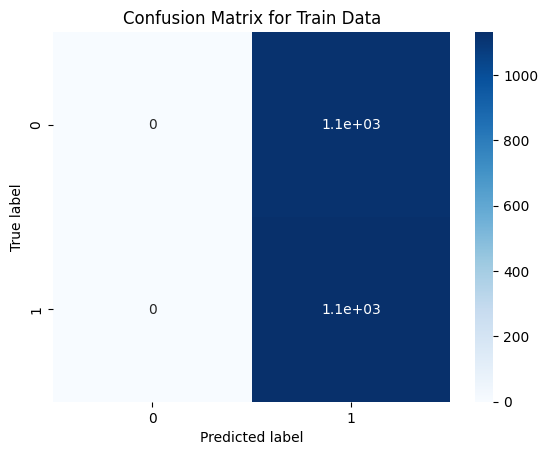

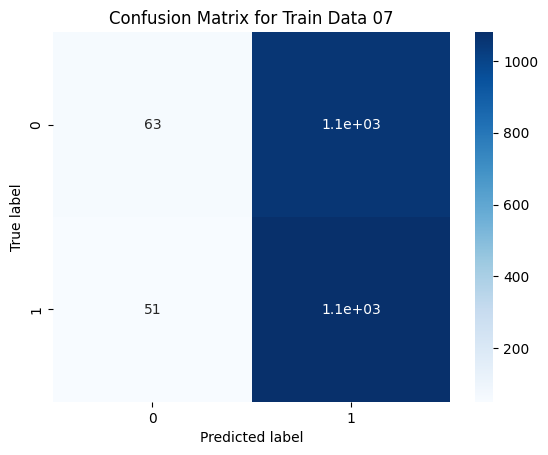

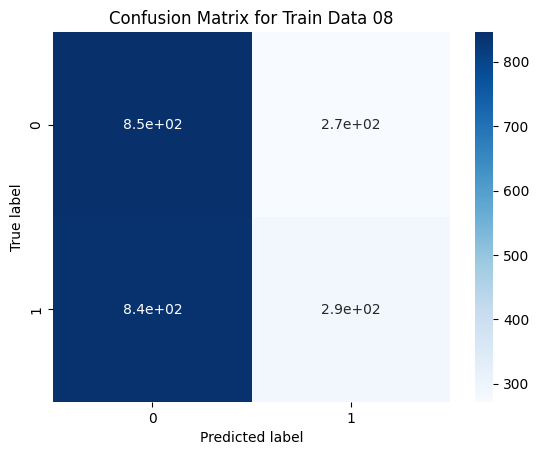

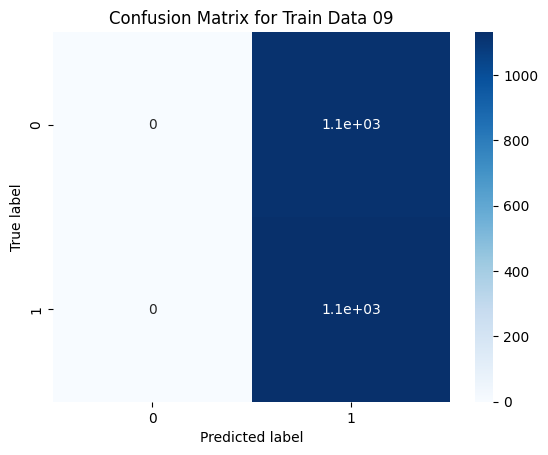

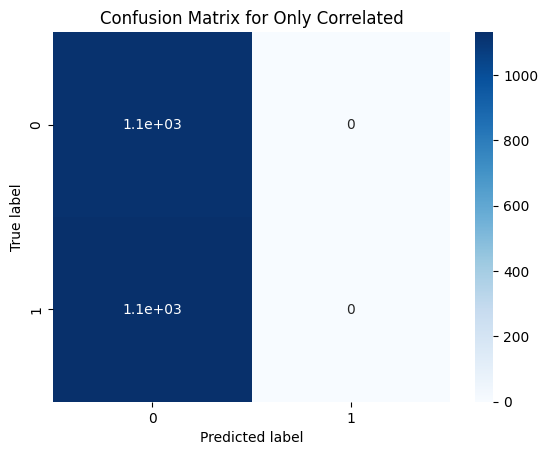

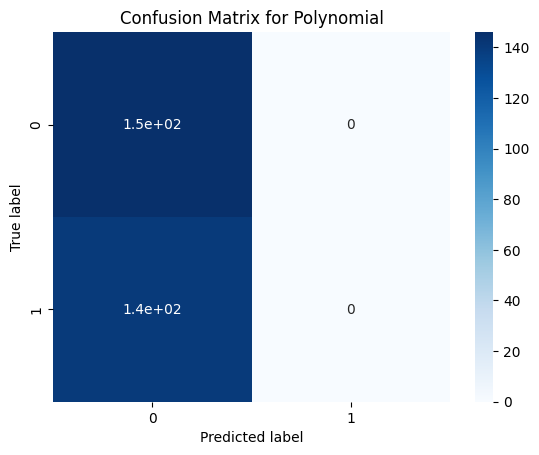

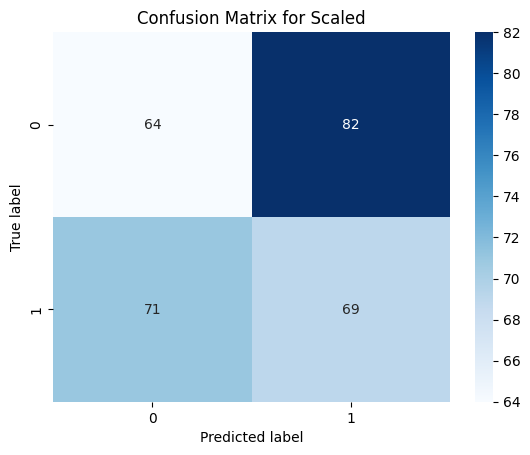

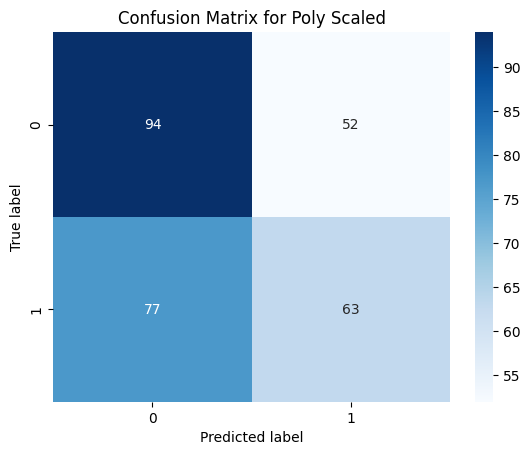

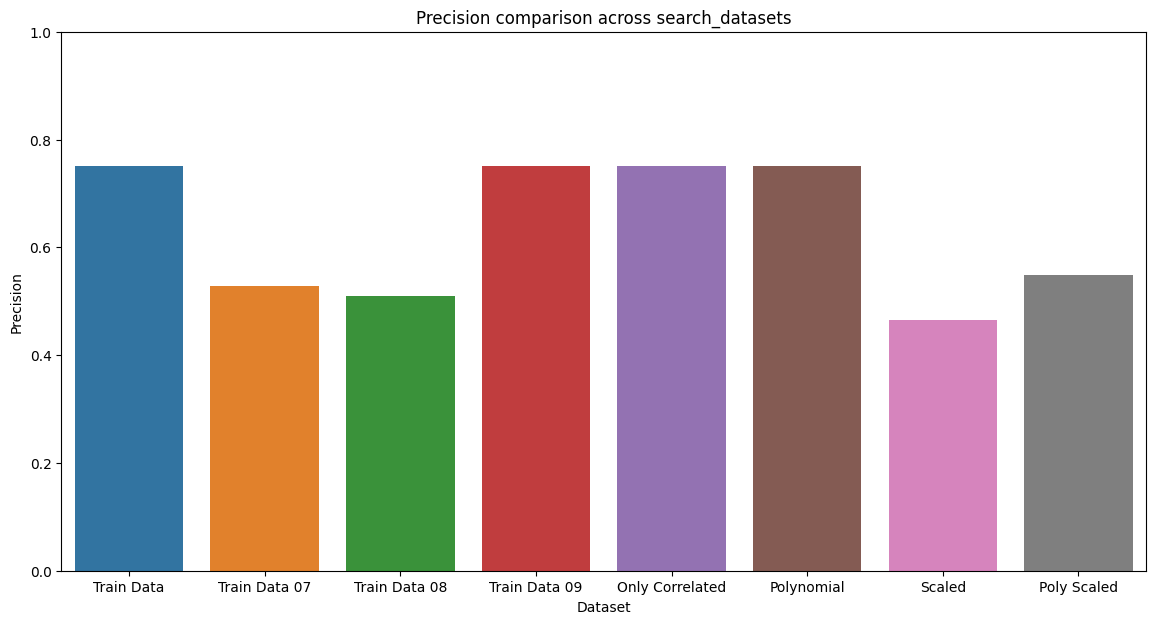

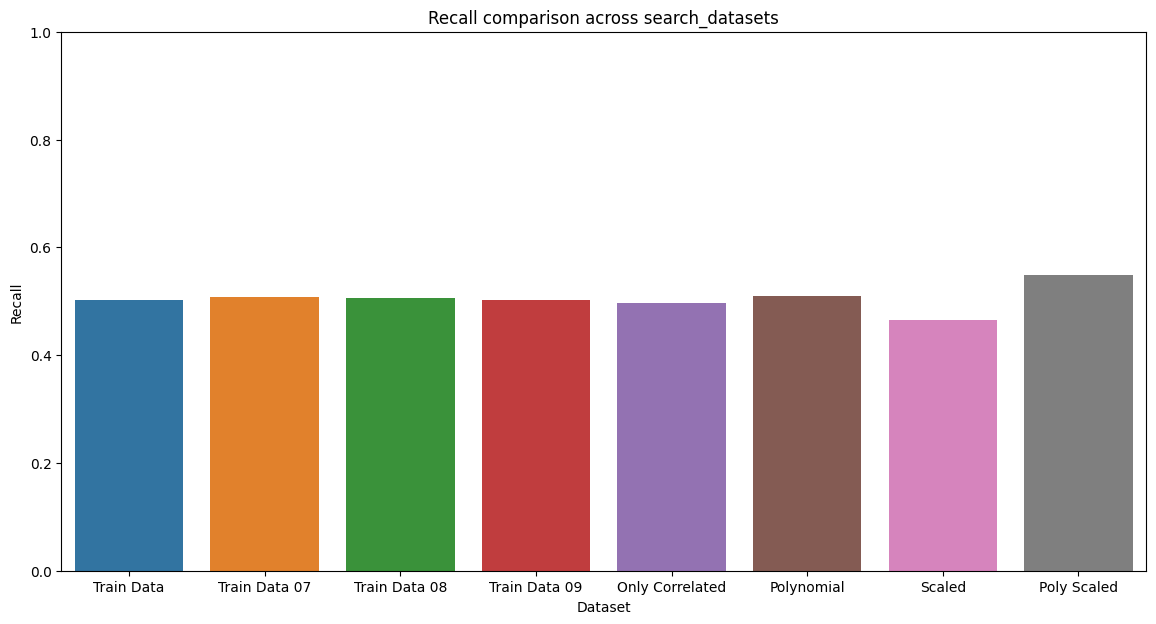

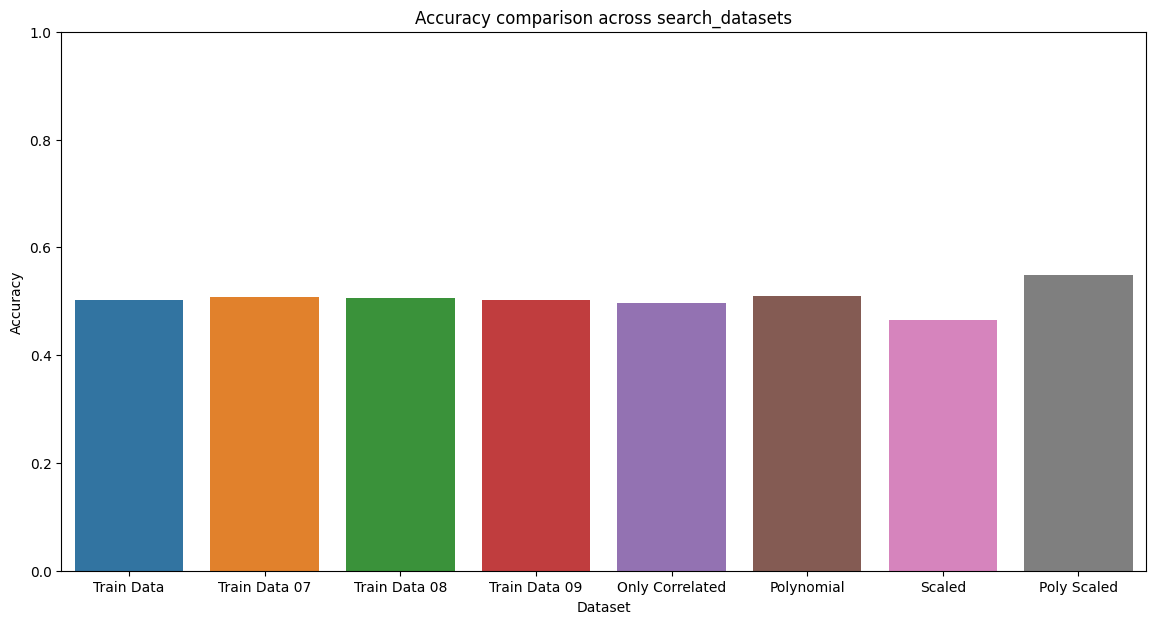

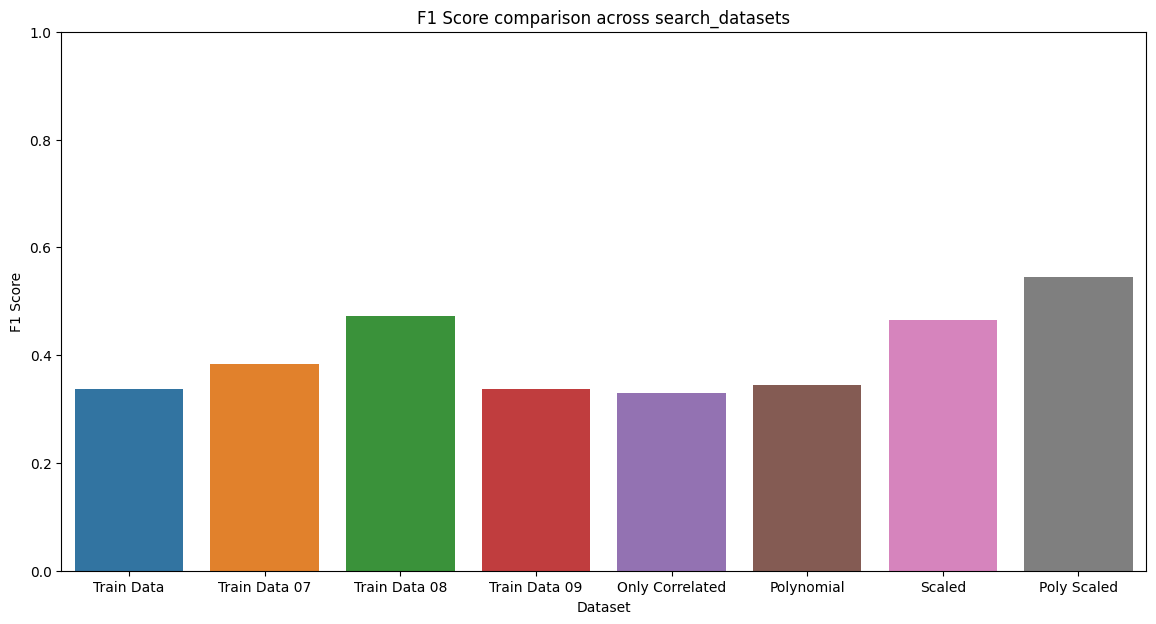

In [33]:
params = {
    'loss': ['hinge', 'log', 'modified_huber'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [1000, 2000, 3000],
    'tol': [1e-3, 1e-4, 1e-5]
}


grid_search_analysis(target_column, params, SGDClassifier(), datasets, names)

SGD shows very similar results when it comes to accuracy. Again, some of the datasets only selected one option in the target feature leading to high precision.

From other tests, we concluded that our data is not linearly separable, which is something we can confirm looking at the `loss` parameter. It mostly chooses the `log` option, which is more suitable to use when the data is non-linearly separable data.

Looking to the `penalty` parameter, our data sets normally prefer the `l1` option, which is an option that penalizes absolute weights (better for feature selection). `l2` is another good option, which penalizes the sum of the squared weights.



### In conclusion, the decision tree model achieved the best results, with over 60% accuracy on the Only Correlated dataset.

### We could still improve the results with better data engineering and incorporating more data samples (i.e. more records of insured vehicles).

### This project provided valuable insights into the various classification techniques and helped clarify the differences between some machine learning models.